## Общие сведения

### Краткое описание проекта

В рамках проекта планируется разработать модель машинного обучения предсказывающую риск сердечного приступа, а также подготовить библиотеку и интерфейс к ней для предсказания на тестовой выборке.

### План работ

- Провести загрузку и предобработку данных (анализ пропусков, приведение типов и т.п.)
- Провести исследовательский анализ данных, построить графики
- Провести корреляционный анализ данных
- Обучить модель
- Получить предсказание на тестовой выборке
- Обобщить результаты исследования

### Описание данных

Датасеты содержат следующие данные:

- `Age` - Возраст пациента
- `Cholesterol` - Уровень холестерина
- `Heart rate` - Пульс (наверное)
- `Diabetes` - Наличие диабета
- `Family History` - Наличие проблем с сердцем в семье (двоичный)
- `Smoking` - Курение (двоичный)
- `Obesity` - Ожирение (двоичный)
- `Alcohol Consumption` - Употребление алкоголя (двоичный)
- `Exercise Hours Per Week` - Количество часов физических упражнений в неделю
- `Diet` - Диета
- `Previous Heart Problems` - Предыдущие проблемы с сердцем (двоичный)
- `Medication Use` - Прием лекарств (двоичный)
- `Stress Level` - Уровень стресса
- `Sedentary Hours Per Day` - Количество часов сидячего Образа жизни в день
- `Income` - Доход
- `BMI` - Индекс массы тела (ИМТ)
- `Triglycerides` - Уровень триглицеридов
- `Physical Activity Days Per Week` - Дней физической активности в неделю
- `Sleep Hours Per Day` - Количество часов сна в день
- `Heart Attack Risk (Binary)` - Риск сердечного приступа (двоичный, целевой признак)
- `Blood sugar` - Уровень сахара в крови
- `CK-MB` - Уровень фермента креатинкиназы
- `Troponin` - Уровень тропонина
- `Gender` - Пол
- `Systolic blood pressure` - Систолическое артериальное давление
- `Diastolic blood pressure` - Диастолическое артериальное давление
- `id` - идентификатор пациента

### Подготовительное

In [1]:
import os
import re
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from catboost import CatBoostClassifier, Pool
from imblearn.combine import SMOTEENN, SMOTETomek
from IPython.display import display
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score, roc_auc_score)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from torch.utils.data import DataLoader, Dataset

pd.options.mode.chained_assignment = None
pd.options.display.float_format ='{:,.3f}'.format
pd.options.display.max_columns = None

PRO_PATH = os.path.join(os.getcwd(), 'source')
PERC = [0.01, 0.25, 0.5, 0.75, 0.99]
RANDOM_STATE = 42

## Загрузка данных

In [2]:
if os.path.exists(PRO_PATH):
    df = pd.read_csv(os.path.join(PRO_PATH, 'heart_train.csv'))
    test_data = pd.read_csv(os.path.join(PRO_PATH, 'heart_test.csv'))
else:
    print('Датасеты не обнаружены')

In [3]:
display(df.sample(3))
df.info()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
8632,8632,0.640,0.725,0.037,1.000,0.000,1.000,0.000,1.000,0.430,0,0.000,0.000,9.000,0.083,0.318,0.509,0.877,3.000,0.333,0.000,0.326,0.003,0.001,Male,0.535,0.419,1585
7091,7091,0.404,0.382,0.069,0.000,0.000,1.000,1.000,0.000,0.037,2,0.000,0.000,3.000,0.778,0.402,0.193,0.005,5.000,0.667,0.000,0.178,0.009,0.000,Male,0.355,0.465,4599
7826,7826,0.573,0.439,0.023,1.000,1.000,1.000,0.000,1.000,0.728,2,0.000,1.000,10.000,0.809,0.299,0.318,0.697,7.000,1.000,1.000,0.227,0.048,0.037,Male,0.703,0.465,8974


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

In [4]:
display(test_data.sample(3))
test_data.info()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
932,932,0.787,0.739,0.055,1.000,0.000,1.000,0.000,1.000,0.655,0,1.000,1.000,6.000,0.553,0.424,0.464,0.356,3.000,0.000,0.227,0.048,0.037,Male,0.245,0.314,1803
99,99,0.506,0.775,0.044,1.000,0.000,1.000,1.000,0.000,0.308,1,1.000,1.000,3.000,0.966,0.189,0.391,0.748,5.000,0.833,0.227,0.048,0.037,Male,0.361,0.465,2543
457,457,0.371,0.539,0.054,0.000,1.000,1.000,1.000,0.000,0.514,1,1.000,0.000,7.000,0.084,0.820,0.643,0.142,3.000,0.167,0.338,0.019,0.000,Female,0.658,0.442,7662


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null    float64
 10  Diet                             966 non-null    int64  
 11  Previous Heart Problems          935 non-null    float64
 12  Medication Use        

### Вывод

Тренировочные и тестовые данные загружены успешно

## Предобработка данных

In [5]:
# Исключение из данных столбца 'Unnamed: 0' (номер записи)
df.drop(columns=['Unnamed: 0'], inplace=True)
test_data.drop(columns=['Unnamed: 0'], inplace=True)

### Переименование

In [6]:
def rename_columns_to_snake_case(df: pd.DataFrame) -> pd.DataFrame:
    """Переименовывает все столбцы DataFrame в стиль snake_case."""
    column_mapping = {col: re.sub(r'[()]', '', col).lower().replace(' ', '_').replace('-', '_') for col in df.columns}
    renamed_df = df.rename(columns=column_mapping)

    if df.shape != renamed_df.shape:
        raise ValueError('Размер DataFrame изменился после переименования!')
    return renamed_df

df = rename_columns_to_snake_case(df)
test_data = rename_columns_to_snake_case(test_data)

if sorted(df.drop(columns=['heart_attack_risk_binary']).columns) != sorted(test_data.columns):
    raise NameError('Наименования столбцов тренировочного и тестового DataFrame не совпадают!')

### Предварительный анализ дубликатов и пропусков

In [7]:
display(df.gender.value_counts())
test_data.gender.value_counts()

gender
Male      5882
Female    2560
1.0        156
0.0         87
Name: count, dtype: int64

gender
Male      650
Female    285
1.0        22
0.0         9
Name: count, dtype: int64

In [8]:
for data, name in ((df, 'Тренировочный'), (test_data, 'Тестовый')):
    print(f'Датасет {name}')
    print(f'Количество пропусков в данных: {data.isna().sum().max()} ({(data.isna().sum().max() / len(data) * 100):.2f}% от объема данных)')
    print(f'Количество явных дубликатов: {data.duplicated().sum()}')
    print('*' * 40)

Датасет Тренировочный
Количество пропусков в данных: 243 (2.80% от объема данных)
Количество явных дубликатов: 0
****************************************
Датасет Тестовый
Количество пропусков в данных: 31 (3.21% от объема данных)
Количество явных дубликатов: 0
****************************************


### Неявные дубликаты

In [9]:
# Анализ уникальности id
assert len(df.id.unique()) == len(df), 'В Тренировочных данных присутствуют повторы "id"!'
assert len(test_data.id.unique()) == len(test_data), 'В Тестовых данных присутствуют повторы "id"!'

### Выводы

Проведена предобработка данных:
- Наименования колонок приведены к snake_case
- Проверено наличия явных дубликатов. Явные дубликаты не обнаружены.
- Проверено наличие дубликатов `id` записей. Дубликатов нет
- Проверено наличие явных пропусков - пропусков менее 5% от всего датасета.

Решение по заполнению пропусков будет принято после анализа данных

## Исследовательский анализ данных

### Анализ пропусков

In [10]:
have_nan_cols = [col for col in df.columns if df[col].isna().sum() > 0]

def check_missing_alignment(df: pd.DataFrame, cols: list) -> bool:
    """
    Функция проверяет, находятся ли пропуски данных в указанных колонках
    в одних и тех же строках DataFrame.
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("df должен быть экземпляром pd.DataFrame")
    if not isinstance(cols, list):
        raise ValueError("cols должен быть списком")
    if len(cols) < 2:
        raise ValueError("Необходимо указать минимум две колонки для сравнения")
    
    masks = [df[col].isna() for col in cols]
    result = masks[0]
    for mask in masks[1:]:
        result = result & mask
    
    return result.sum() == df[cols[0]].isna().sum()

print(f'Колонок с пропусками: {len(have_nan_cols)} ({(len(have_nan_cols)/len(df.columns) * 100):.2f}%)')
assert check_missing_alignment(df, have_nan_cols), 'В Тренировочных данных пропуски в разных строках!'
if 'heart_attack_risk_binary' in have_nan_cols:
    have_nan_cols.pop('heart_attack_risk_binary')
assert check_missing_alignment(test_data, have_nan_cols), 'В Тестовых данных пропуски в разных строках!'

Колонок с пропусками: 9 (33.33%)


In [11]:
def gender_printer(df: pd.DataFrame, nan_col: str, df_name: str):
    """Печатает значения признака `gender` для строк с пропусками и без"""
    print(f'---- Датасет {df_name} ----')
    print('Значение "gender" в строках с пропусками')
    print(df[df[nan_col].isna()].gender.value_counts())
    print('Значение "diet" в строках с пропусками')
    print(df[df[nan_col].isna()].diet.value_counts())
    print('Значение "gender" в строках без пропусков')
    print(df[df[nan_col].notna()].gender.value_counts())
    print('Значение "diet" в строках с пропусками')
    print(df[df[nan_col].notna()].diet.value_counts())
    print('*' * 40)

gender_printer(df, 'diabetes', 'Тренировочный')
gender_printer(test_data, 'diabetes', 'Тестовый')

---- Датасет Тренировочный ----
Значение "gender" в строках с пропусками
gender
1.0    156
0.0     87
Name: count, dtype: int64
Значение "diet" в строках с пропусками
diet
3    243
Name: count, dtype: int64
Значение "gender" в строках без пропусков
gender
Male      5882
Female    2560
Name: count, dtype: int64
Значение "diet" в строках с пропусками
diet
1    2863
2    2796
0    2783
Name: count, dtype: int64
****************************************
---- Датасет Тестовый ----
Значение "gender" в строках с пропусками
gender
1.0    22
0.0     9
Name: count, dtype: int64
Значение "diet" в строках с пропусками
diet
3    31
Name: count, dtype: int64
Значение "gender" в строках без пропусков
gender
Male      650
Female    285
Name: count, dtype: int64
Значение "diet" в строках с пропусками
diet
0    322
2    312
1    301
Name: count, dtype: int64
****************************************


In [12]:
df[df.diet!=3].describe(percentiles=PERC).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
age,"8,442.000",0.449,0.233,0.045,0.045,0.247,0.461,0.640,0.854,0.854
cholesterol,"8,442.000",0.501,0.289,0.000,0.007,0.261,0.496,0.750,0.993,1.000
heart_rate,"8,442.000",0.050,0.018,0.018,0.018,0.035,0.050,0.066,0.082,0.082
diabetes,"8,442.000",0.652,0.476,0.000,0.000,0.000,1.000,1.000,1.000,1.000
family_history,"8,442.000",0.490,0.500,0.000,0.000,0.000,0.000,1.000,1.000,1.000
smoking,"8,442.000",0.903,0.296,0.000,0.000,1.000,1.000,1.000,1.000,1.000
obesity,"8,442.000",0.498,0.500,0.000,0.000,0.000,0.000,1.000,1.000,1.000
alcohol_consumption,"8,442.000",0.602,0.490,0.000,0.000,0.000,1.000,1.000,1.000,1.000
exercise_hours_per_week,"8,442.000",0.503,0.289,0.000,0.008,0.253,0.508,0.755,0.990,1.000
diet,"8,442.000",1.002,0.813,0.000,0.000,0.000,1.000,2.000,2.000,2.000


In [13]:
df[df.diet==3].describe(percentiles=PERC).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
age,243.000,0.483,0.162,0.000,0.113,0.371,0.517,0.579,0.924,1.000
cholesterol,243.000,0.500,0.000,0.500,0.500,0.500,0.500,0.500,0.500,0.500
heart_rate,243.000,0.067,0.087,0.000,0.029,0.046,0.057,0.070,0.105,1.000
diabetes,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
family_history,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smoking,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
obesity,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alcohol_consumption,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exercise_hours_per_week,243.000,0.502,0.000,0.502,0.502,0.502,0.502,0.502,0.502,0.502
diet,243.000,3.000,0.000,3.000,3.000,3.000,3.000,3.000,3.000,3.000


Анализ показал, что:

- все пропуски находятся в одних и тех же строках;
- аномальные (не поддающиеся однозначной трактовке) значения признака `gender` находятся в строках с пропущенными значениями,
- в строках без пропусков нет аномальных значений признака `gender` (только `Male` и `Female`)
- в строках с пропусками значение признака `diet` == 3, в строках без пропусков  `diet` == [0, 2]
- в трети признаков данне фиктивные (например, `cholesterol` == 0.5 для всех строк).

**ИТОГО** в строках с пропусками треть данных пропущена, треть - фиктивные. Данные не пригодны для использования. Возможная причина - некорректное объединение данных. Принято решение исключить данные из датасетов

In [14]:
def dropna_with_control(df: pd.DataFrame, name: str) -> pd.DataFrame:
    """
    Функция для безопасного удаления строк с пропущенными значениями из DataFrame.
    Дополнительно контролирует столбец "gender", при наличии.
    """
    data = df.copy()

    data_loss = data.isna().sum().max() / len(data)
    start_size = data.shape

    data.dropna(inplace=True)
    assert data.shape[0] == start_size[0] * (1 - data_loss), 'Потери данных превышают теоретические!'
    assert data.shape[1] == start_size[1], 'При исключении пропусков потеряны колонки!'
    print(f'Удалено пропусков в {name}:', start_size[0] - data.shape[0])
    print(f'Остаток данных: {(data.shape[0] / start_size[0] * 100):.2f}%')

    if 'gender' in data:  
        assert sorted(data.gender.unique()) == sorted(['Female', 'Male']), f'Ошибка при удалении данных из {name}'
        data['gender'] = data['gender'].apply(lambda x: 0 if x == 'Female' else 1)
        assert sorted(data.gender.unique()) == sorted([0, 1]), f'Ошибка при замене "gender" данных из {name}'
    
    return data

df = dropna_with_control(df, 'Тренировочный')
test_data = dropna_with_control(test_data, 'Тестовый')

Удалено пропусков в Тренировочный: 243
Остаток данных: 97.20%
Удалено пропусков в Тестовый: 31
Остаток данных: 96.79%


### Приведение типов

In [15]:
def convert_float_to_int(df: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    """Функция для преобразования значений указанных колонок из float в int."""
    assert df[columns].isna().sum().sum() == 0, "В данных присутствуют NaN"

    data = df.copy()

    for col in columns:
        data[col] = data[col].astype(int)
    
    assert data.shape == df.shape, "Размер DataFrame изменился после преобразования"
    for col in columns:
        assert np.issubdtype(data[col].dtype, np.integer), f"Колонка {col} не была преобразована в int"
    
    return data

cols = ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'previous_heart_problems',
        'medication_use', 'gender', 'heart_attack_risk_binary', 'diet', 'stress_level', 'physical_activity_days_per_week']
df = convert_float_to_int(df, cols)

cols.remove('heart_attack_risk_binary')
test_data = convert_float_to_int(test_data, cols)

### Анализ распределения признаков

In [16]:
binary_cols = [
    {'col': 'diabetes',                 'title': 'Наличие диабета'},
    {'col': 'family_history',           'title': 'Заболевания в семье'},
    {'col': 'smoking',                  'title': 'Пациент курит'},
    {'col': 'obesity',                  'title': 'У пациента ожирение'},
    {'col': 'alcohol_consumption',      'title': 'Пациент пьющий'},
    {'col': 'previous_heart_problems',  'title': 'Проблемы с сердцем ранее'},
    {'col': 'medication_use',           'title': 'Принимает припараты'},
    {'col': 'gender',                   'title': 'Пол', 'cat_zero': 'Женщина', 'cat_one': 'Мужчина'},
    {'col': 'heart_attack_risk_binary', 'title': 'Риск (таргет)'}
]

category_cols = [
    {'col': 'diet',                            'title': 'Тип диеты'},
    {'col': 'stress_level',                    'title': 'Уровень стресса'},
    {'col': 'physical_activity_days_per_week', 'title': 'Физическая активность в неделю'}
]

numeric_cols = [
    {'col': 'age',                      'title': 'Возраст пациента'},
    {'col': 'cholesterol',              'title': 'Уровень холестерина'},
    {'col': 'heart_rate',               'title': 'Условный рейтинг состояния сердца'},
    {'col': 'exercise_hours_per_week',  'title': 'Количество часов физических упражнений в неделю'},
    {'col': 'sedentary_hours_per_day',  'title': 'Количество часов сидячего Образа жизни в день'},
    {'col': 'income',                   'title': 'Доход'},
    {'col': 'bmi',                      'title': 'Индекс массы тела (ИМТ)'},
    {'col': 'triglycerides',            'title': 'Уровень триглицеридов'},
    {'col': 'sleep_hours_per_day',      'title': 'Количество часов сна в день'},
    {'col': 'blood_sugar',              'title': 'Уровень сахара в крови'},
    {'col': 'ck_mb',                    'title': 'Уровень фермента креатинкиназы'},
    {'col': 'troponin',                 'title': 'Уровень тропонина'},
    {'col': 'systolic_blood_pressure',  'title': 'Систолическое артериальное давление'},
    {'col': 'diastolic_blood_pressure', 'title': 'Диастолическое артериальное давление'},
]

assert len(binary_cols + category_cols + numeric_cols) + 1 == len(df.columns), 'Не все колонки учтены в списках!' # +1 это 'id'

#### Бинарные признаки

In [17]:
def draw_pie(df, col, title, cat_zero='Нет', cat_one='Да'):
    data = df[col].value_counts()
    labels = [cat_one, cat_zero]
    if data.index[0] == 0:
        labels = [cat_zero, cat_one]
    plt.pie(data, labels=labels, autopct='%1.1f%%', wedgeprops={'edgecolor': 'white'})
    plt.title(title)

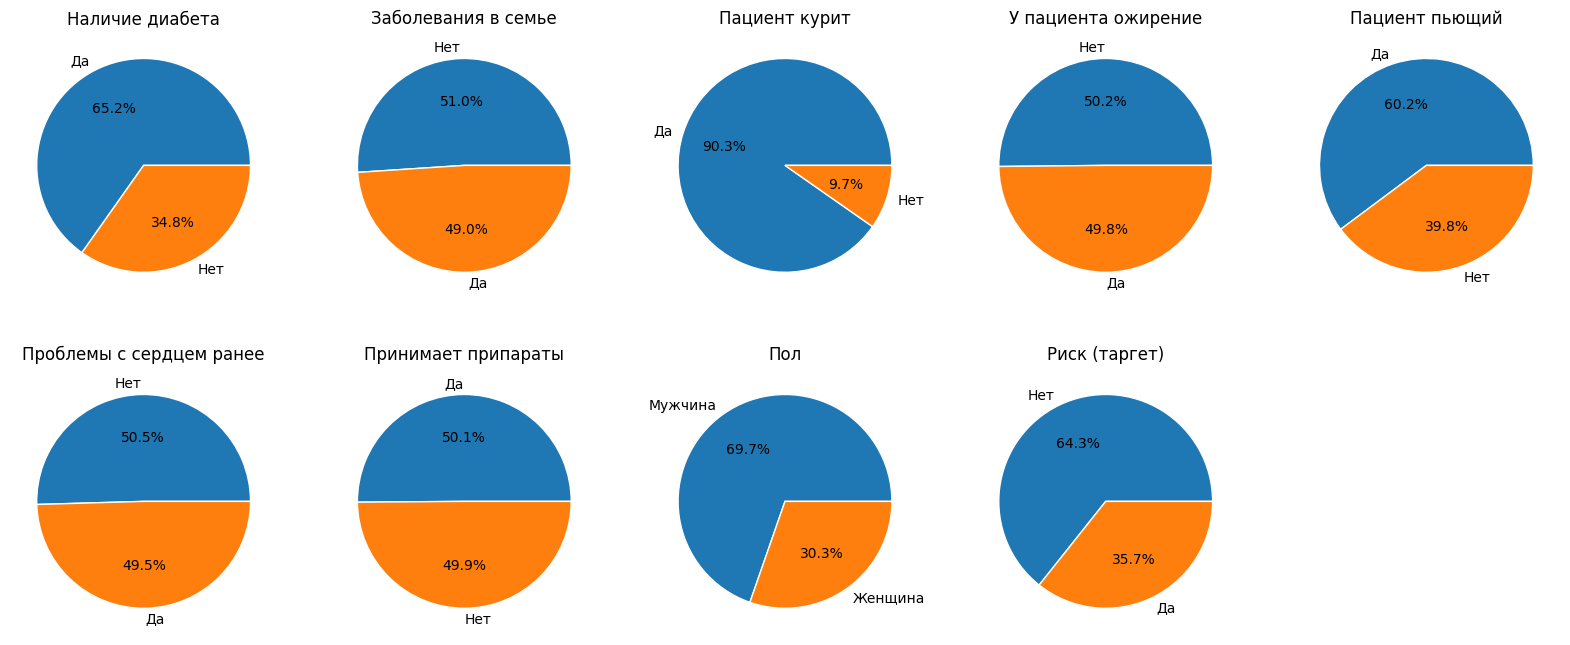

In [18]:
plt.figure(figsize=(20, (len(binary_cols) // 5 + 1) * 4))
for i, col in enumerate(binary_cols):
    plt.subplot(len(binary_cols) // 5 + 1, 5, i+1)
    if 'cat_zero' in col:
        draw_pie(df[df.diet!=3], col['col'], col['title'], col['cat_zero'], col['cat_one'])
    else:
        draw_pie(df[df.diet!=3], col['col'], col['title'])

plt.show()

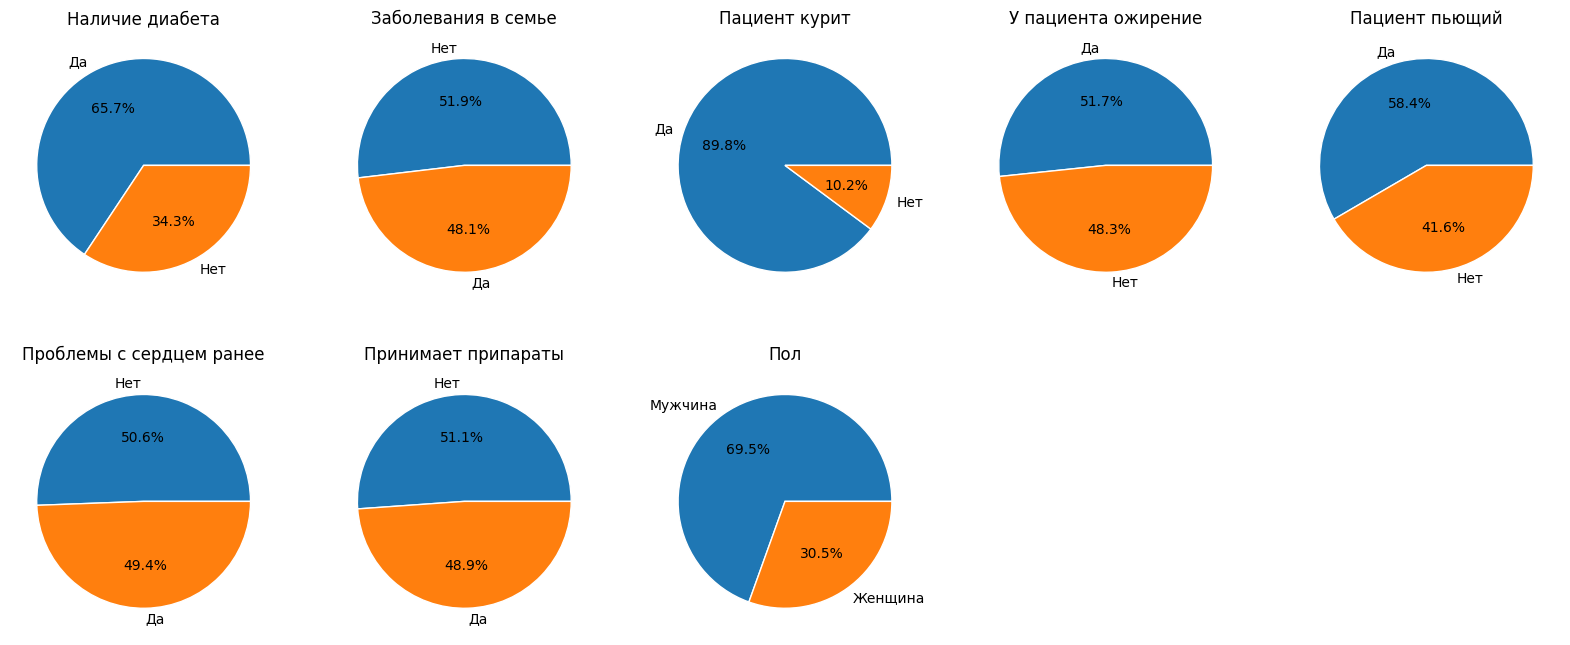

In [19]:
plt.figure(figsize=(20, (len(binary_cols[:-1]) // 5 + 1) * 4))
for i, col in enumerate(binary_cols[:-1]):
    plt.subplot(len(binary_cols[:-1]) // 5 + 1, 5, i+1)
    if 'cat_zero' in col:
        draw_pie(test_data[test_data.diet!=3], col['col'], col['title'], col['cat_zero'], col['cat_one'])
    else:
        draw_pie(test_data[test_data.diet!=3], col['col'], col['title'])

plt.show()

#### Категориальные признаки

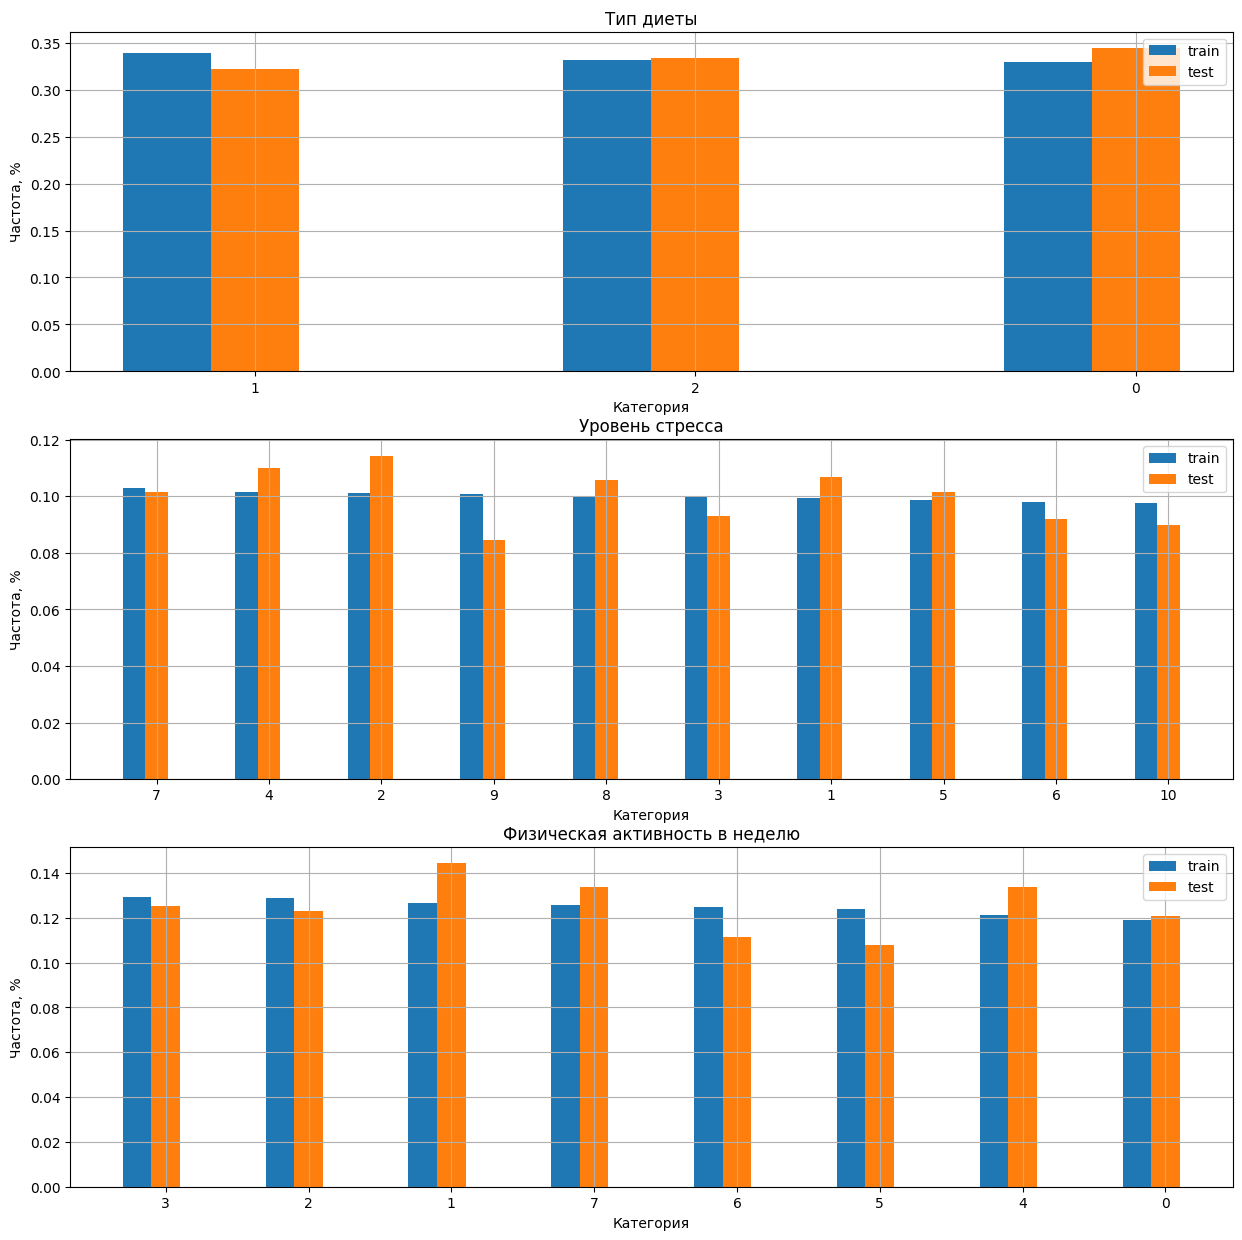

In [20]:
def create_bar(df_list, col, title, legend):
    plt.grid(visible=True)
    plt.title(title)
    plt.xlabel('Категория')
    plt.ylabel('Частота, %')
    width = 0.2
    
    titles = df_list[0][col].value_counts().index
    x = np.arange(len(titles))
    
    for i, data in enumerate(df_list):
        plt.bar(
            x=x-(len(df_list)//2-i)*width, width=width,
            height=data[col].value_counts()[titles] / data.shape[0]
        );
    plt.legend(legend) 
#     plt.xticks(x, titles, rotation=25)
    plt.xticks(x, titles)

plt.figure(figsize=(15, len(category_cols) * 5))
for i, col in enumerate(category_cols):
    plt.subplot(3, 1, i+1)
    create_bar([df, test_data], col['col'], col['title'], ['train', 'test'])
plt.show()

#### Непрерывные признаки

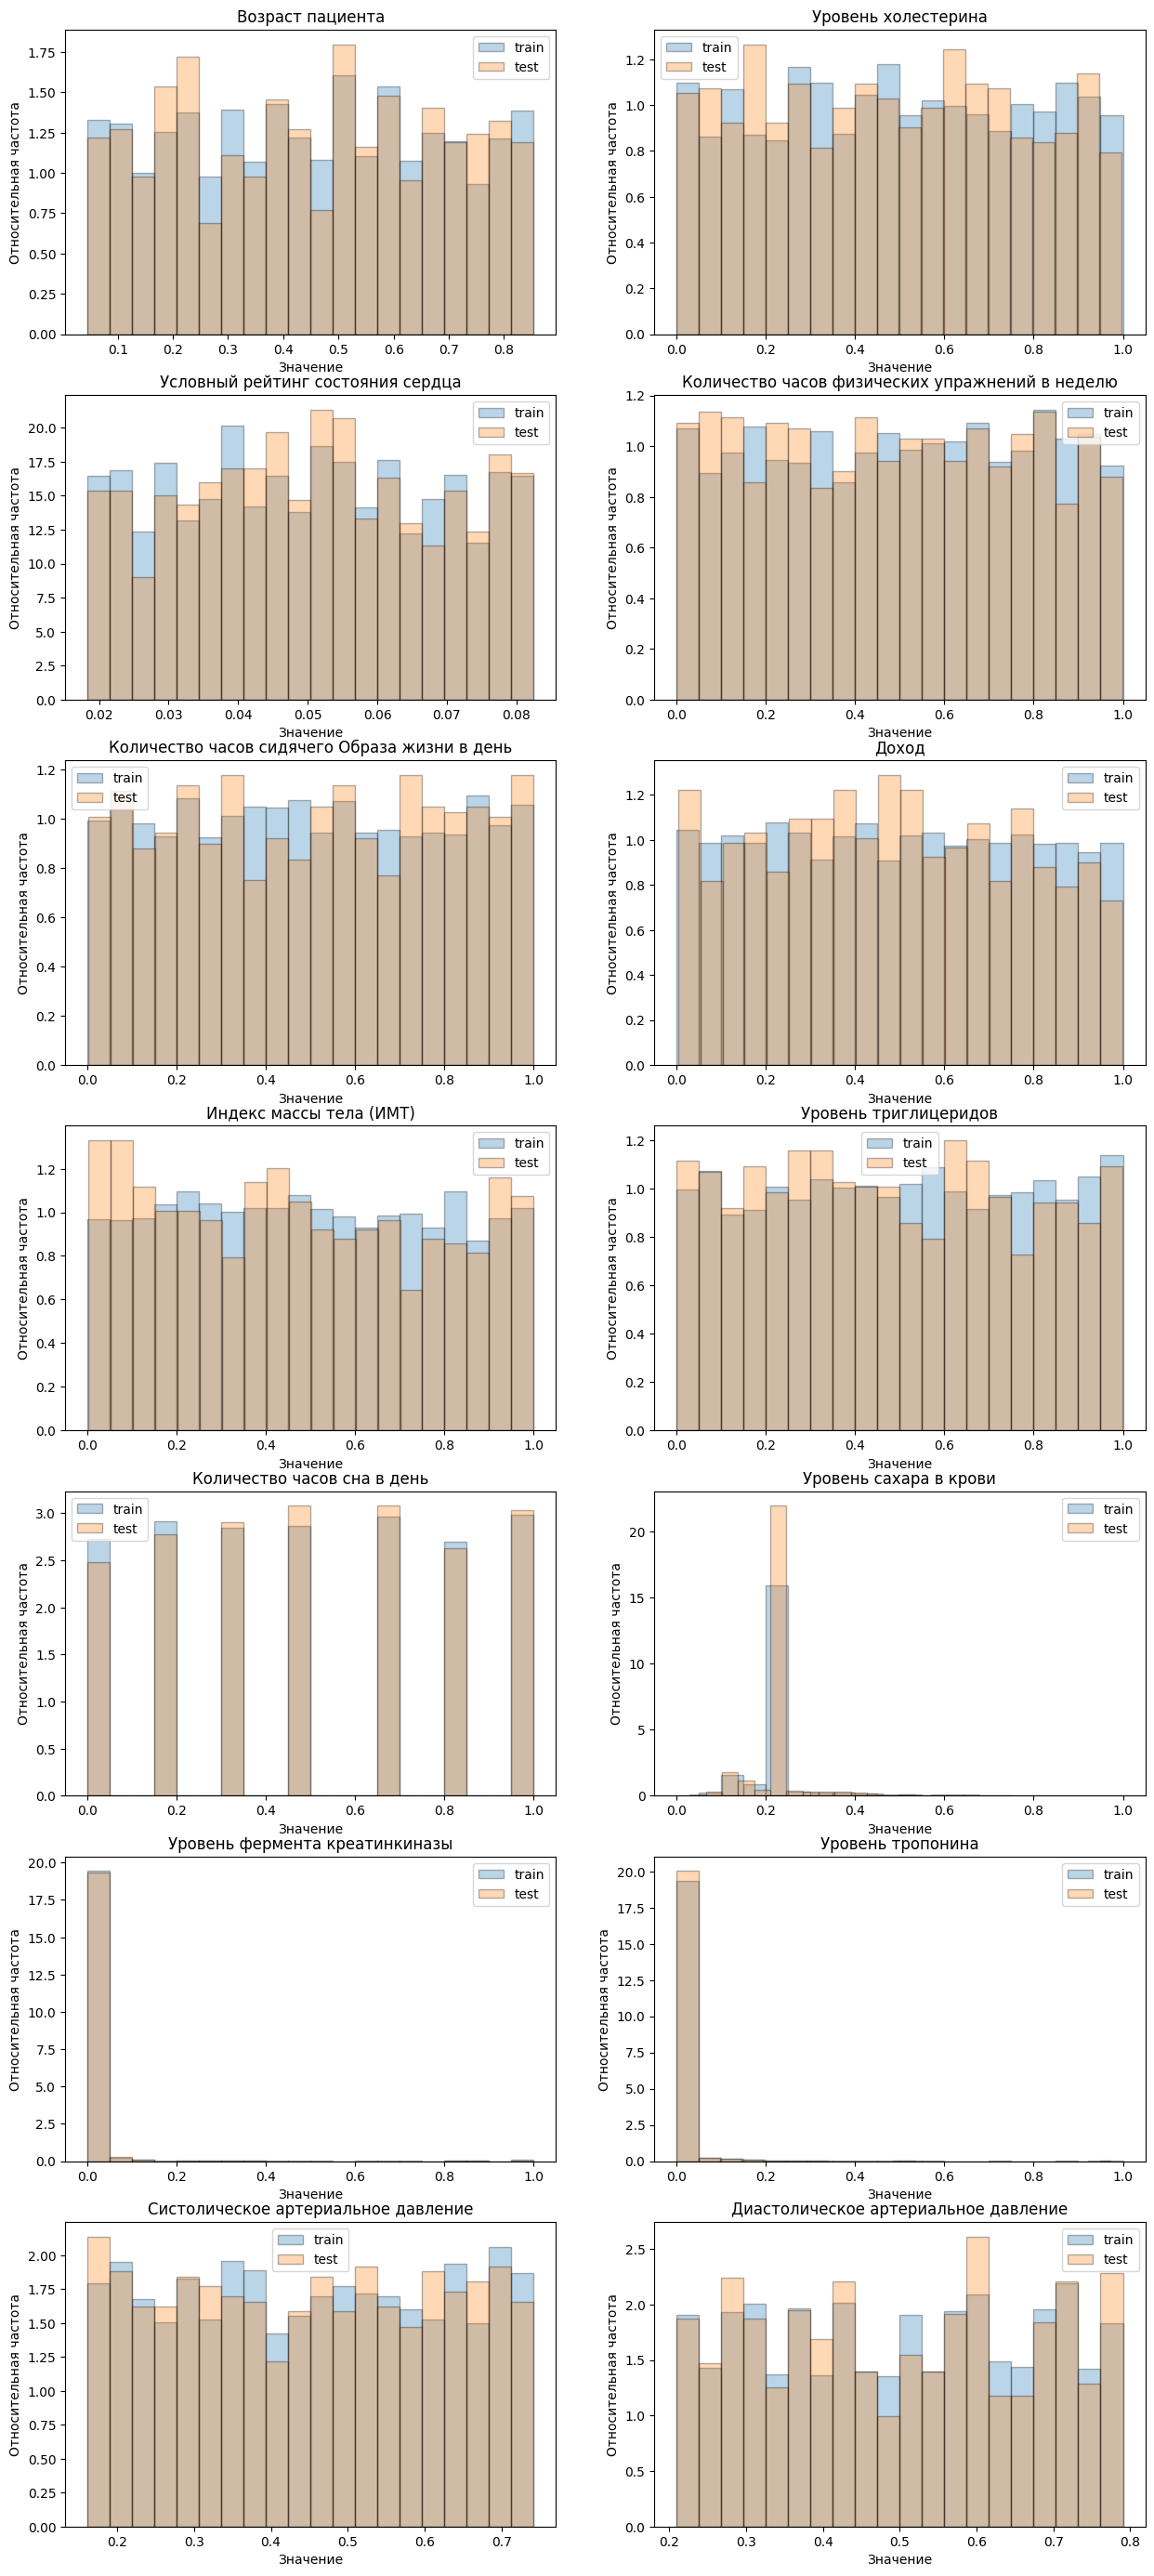

In [21]:
def hists(df_list, col, title, labels, bins=10):
    for i, (data, label) in enumerate(zip(df_list, labels)):
        plt.hist(x=data[col], label=label, edgecolor='black', linewidth=1, alpha=0.3, bins=bins, density=True)
    plt.xlabel('Значение')
    plt.ylabel('Относительная частота')
#     plt.legend(title=title)
    plt.legend()
    plt.title(title)

plt.figure(figsize=(15, (len(numeric_cols)//2+1)*5))
for i, col in enumerate(numeric_cols):
    plt.subplot(len(numeric_cols)//2+1, 2, i+1)
    hists([df, test_data], col['col'], col['title'], ['train', 'test'], bins=20)
plt.show()

#### Целевой признак

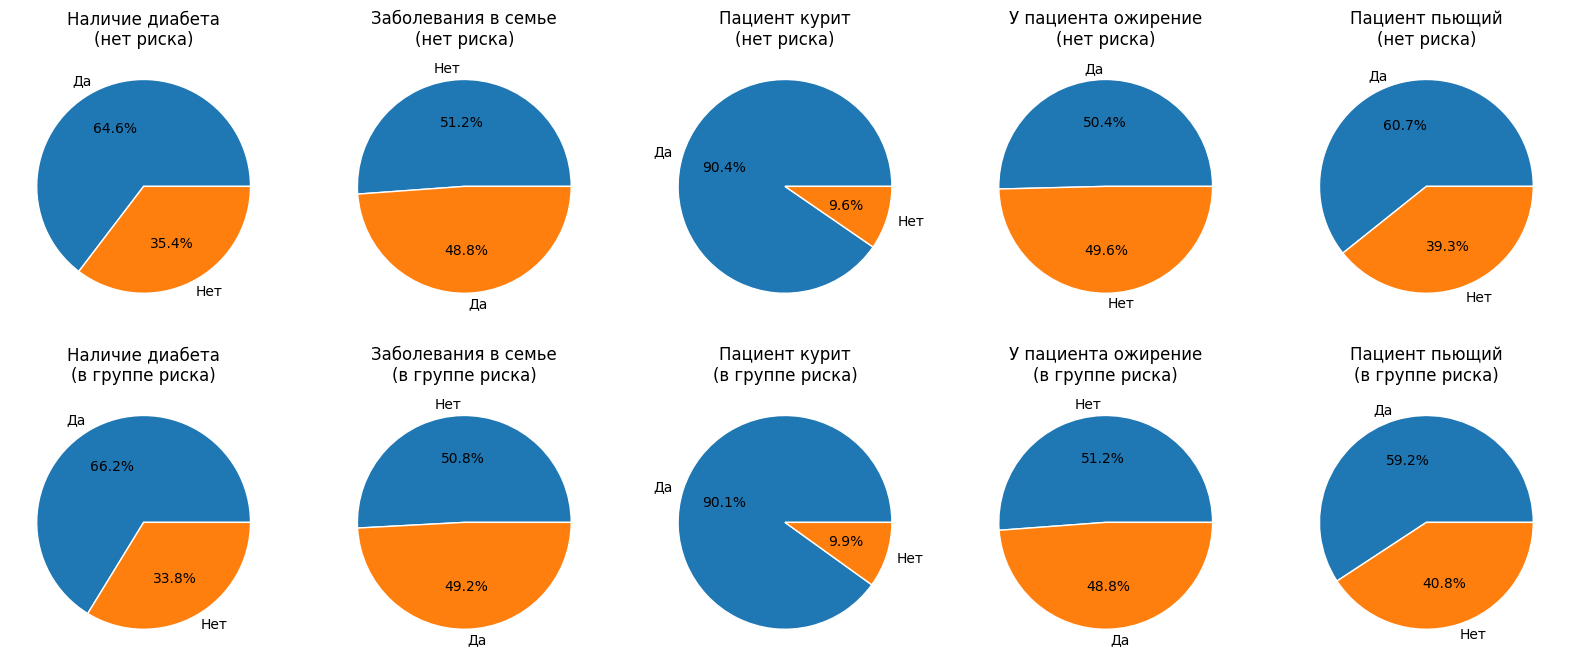

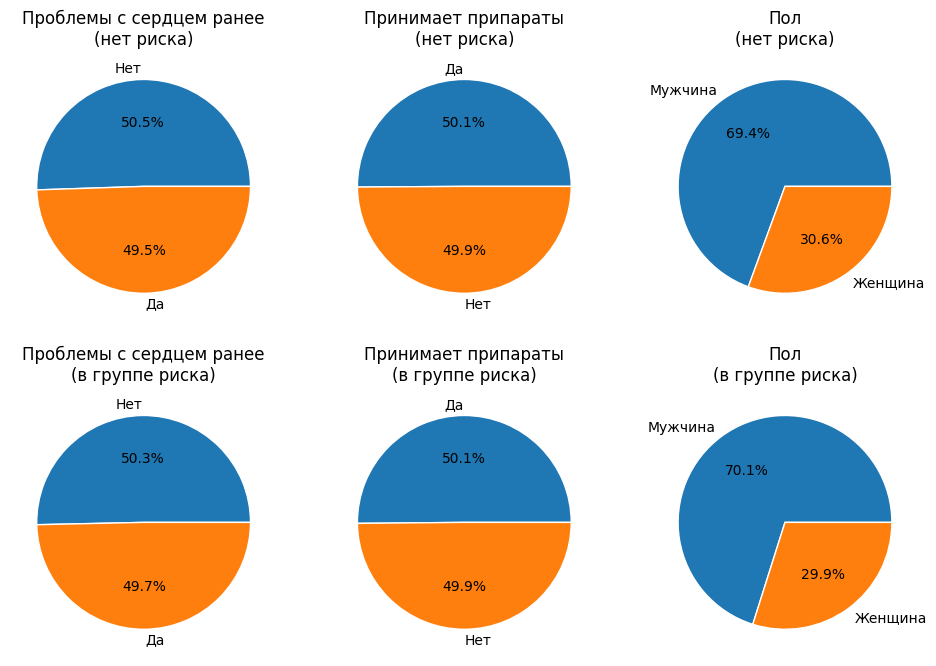

In [22]:
binary_cols_m1 = binary_cols[:-1]
for i in range((len(binary_cols_m1) // 5 + 1)):
    plt.figure(figsize=(20, 8))
    for j, col in enumerate(binary_cols_m1[i*5:i*5+5]):
        plt.subplot(2, 5, j+1)
        if 'cat_zero' in col:
            draw_pie(df[df.heart_attack_risk_binary == 0], col['col'], col['title'] + '\n(нет риска)', col['cat_zero'], col['cat_one'])
        else:
            draw_pie(df[df.heart_attack_risk_binary == 0], col['col'], col['title'] + '\n(нет риска)')
        plt.subplot(2, 5, j+6)
        if 'cat_zero' in col:
            draw_pie(df[df.heart_attack_risk_binary == 1], col['col'], col['title'] + '\n(в группе риска)', col['cat_zero'], col['cat_one'])
        else:
            draw_pie(df[df.heart_attack_risk_binary == 1], col['col'], col['title'] + '\n(в группе риска)')
    plt.show()

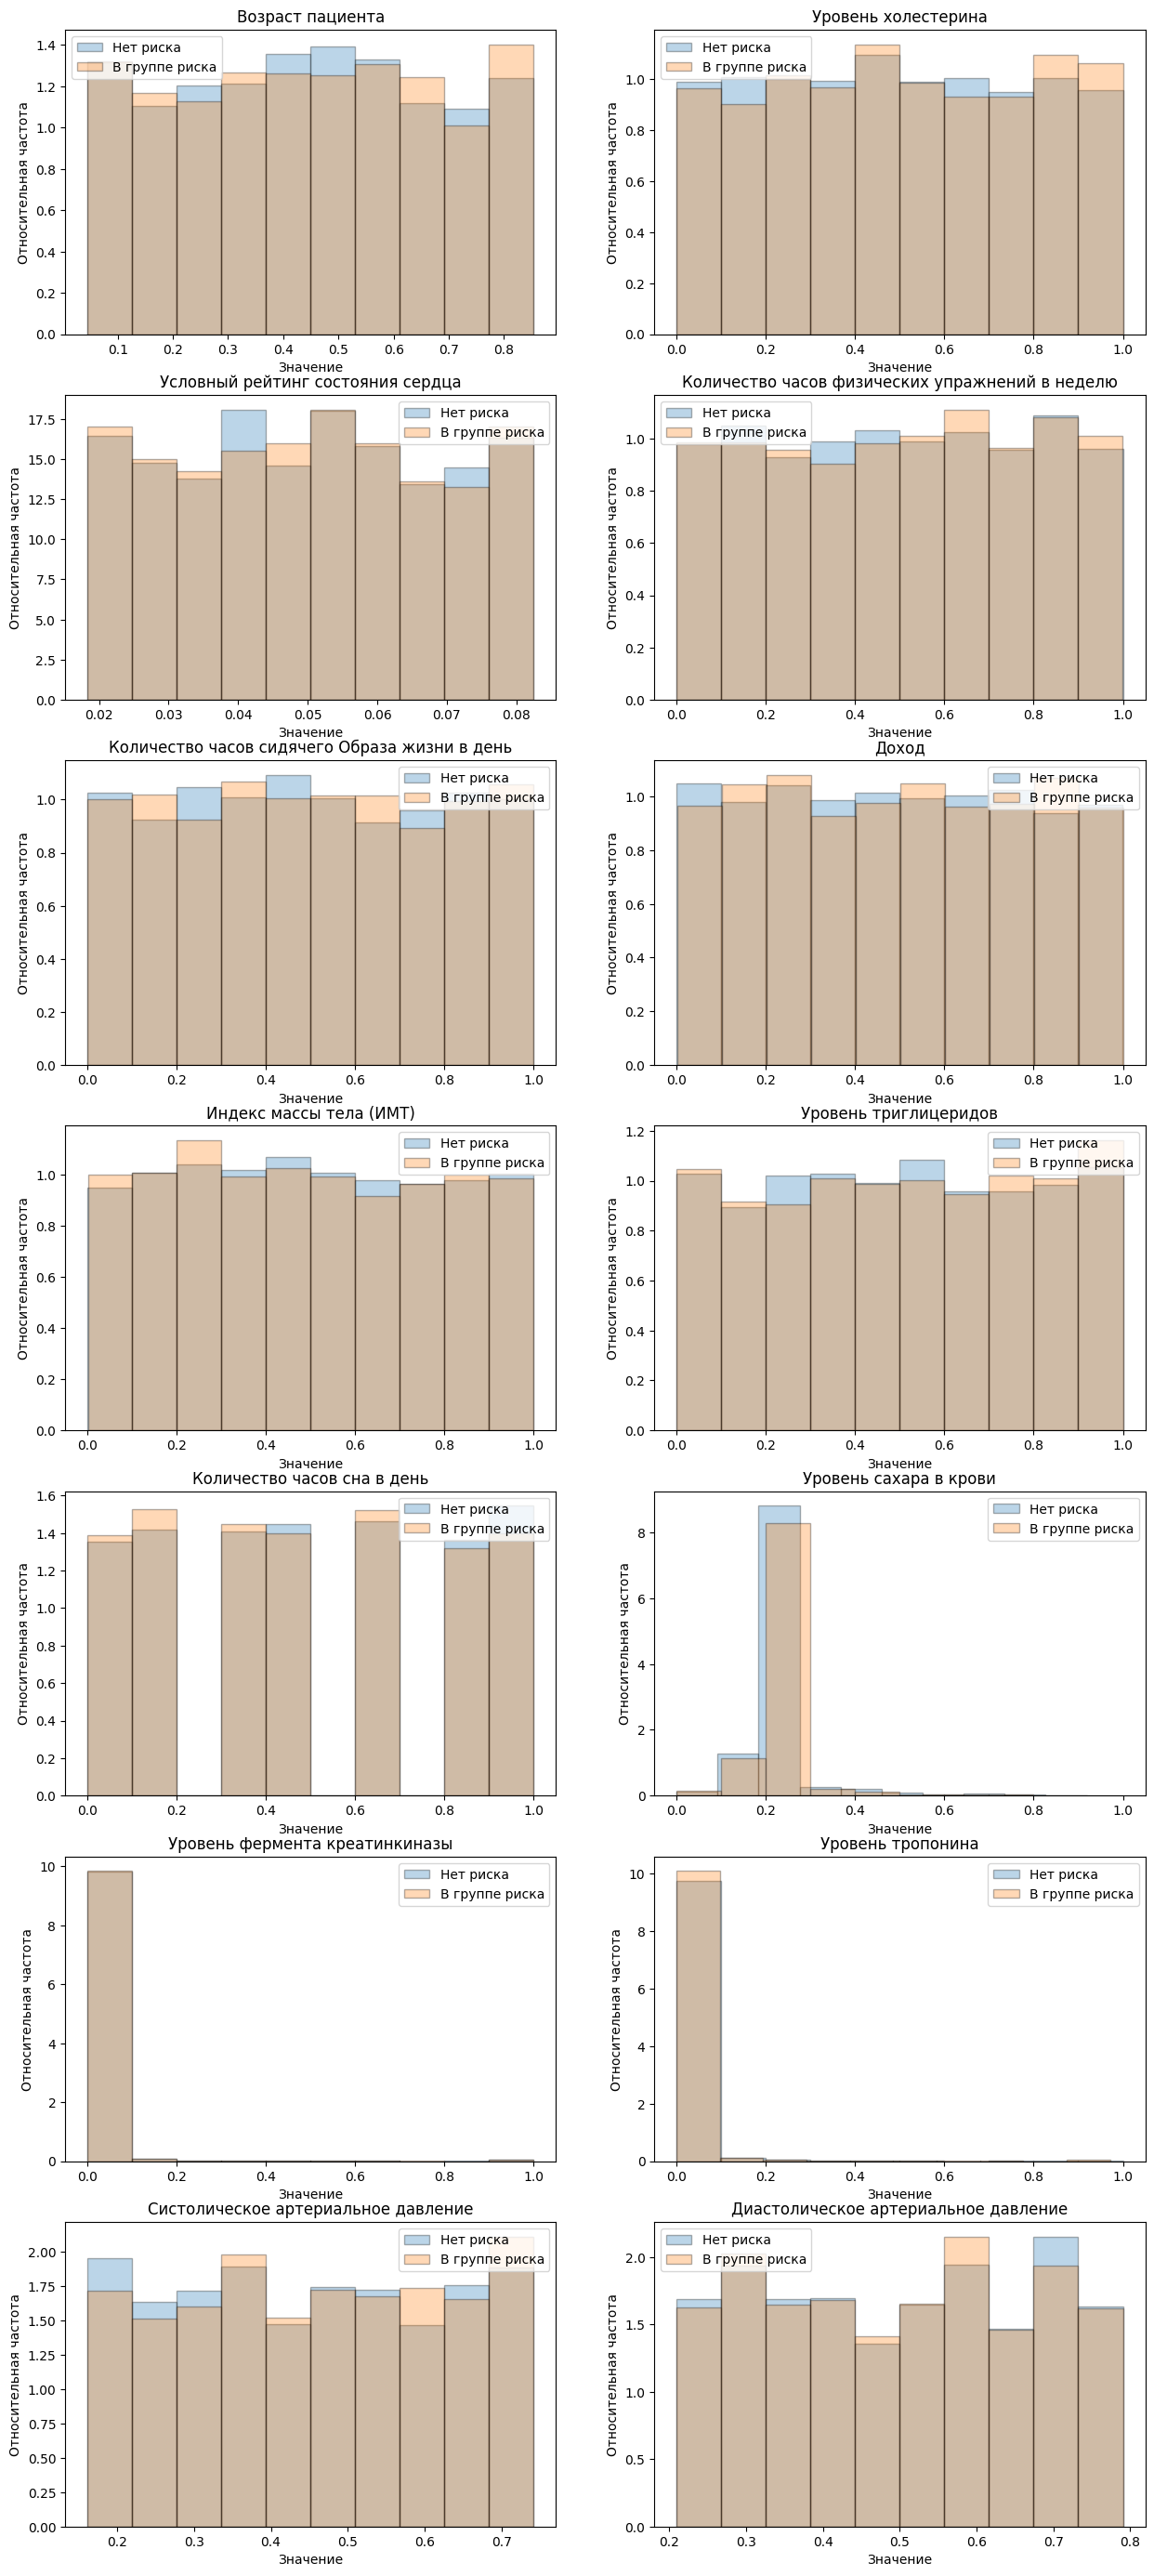

In [23]:
plt.figure(figsize=(15, (len(numeric_cols)//2+1)*5))
for i, col in enumerate(numeric_cols):
    plt.subplot(len(numeric_cols)//2+1, 2, i+1)
    hists(
        [df[df.heart_attack_risk_binary == 0], df[df.heart_attack_risk_binary == 1]],
        col['col'],
        col['title'],
        ['Нет риска', 'В группе риска']
    )
plt.show()

### Корреляционная матрица

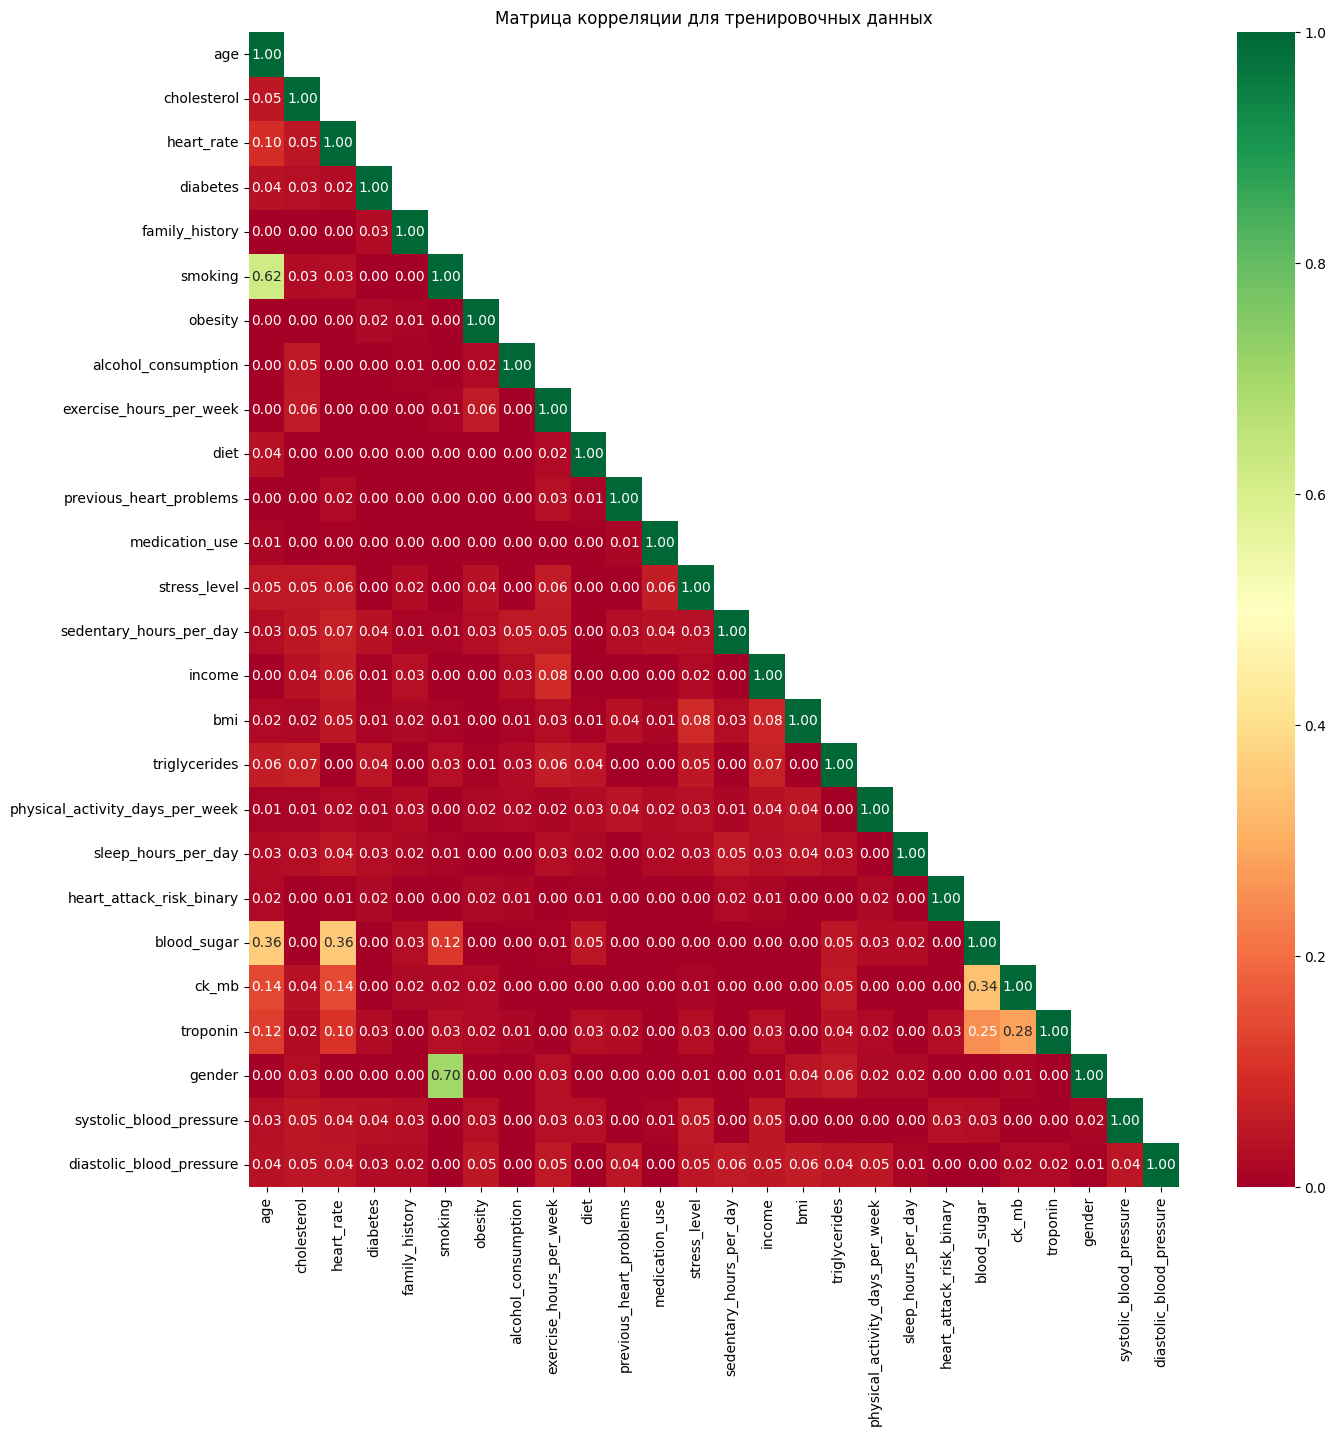

In [24]:
plt.figure(figsize=(15, 15))
corr_matrix = df.drop(columns='id').phik_matrix(interval_cols=[col['col'] for col in numeric_cols])

corr_columns = [
    i for i in corr_matrix['heart_attack_risk_binary'].index
    if corr_matrix['heart_attack_risk_binary'][i] > 0 and i != 'heart_attack_risk_binary'
]

# Угловая
for i in range(0, corr_matrix.shape[0]):
    for j in range (i+1, corr_matrix.shape[0]):
        corr_matrix.iloc[i,j] = np.nan
    
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', fmt='.2f')
plt.title('Матрица корреляции для тренировочных данных')
plt.show()

### Выводы

По результатам исследовательского анализа данных установлено:
- В данных имеются пропуски. После проведённого анализа установлено:
    - все пропуски находятся в одних и тех же строках;
    - аномальные (не поддающиеся однозначной трактовке) значения признака `gender` находятся в строках с пропущенными значениями,
    - в строках без пропусков нет аномальных значений признака `gender` (только `Male` и `Female`)

Возможная причина - некорректное объединение данных. Принято решение исключить строки с пропусками

- Распределение бинарных признаков, в основном, равномерное. Исключения - некурящие пациенты (менее 10% данных), женщины (около 30%) и диабетики (65%).
- Категориальные признаки распределены равномерно, перекосов нет.
- Непрерывные признаки распределены, в основном, нормально. Признаки отнормированы.
- Явных зависимостей целевого признака от конкретного признака не установлено, что подтверждается матрицей корреляции.
- Корреляционная матрица показала сильную зависимость признака `Курение` от признака `Возраст` и `Пол`. Так, в данных отсутствуют записи о некурящих мужчинах. Также отсутствуют данные о некурящих пациентах в возрасте более 0.3 у.е.
- Имеется умеренная корреляция между признаками `Уровень сахара`, `Возраст`, `ЧСС`, `Уровень тропонина` и `Уровень фермента креатинкиназы`.

По результатам исследования принято решение сократить датасет, исключив признаки `Пол` (влияние пола второстепенное), `Курение` (косвенный признак, скорее влияет на рак) и `Доход`.

## Моделирование

In [25]:
class ModelMetrics:
    def __init__(self, model_name):
        self.model_name = model_name
        self.metrics = {}
        self.model = None
        
    def add_metric(self, metric_name, value):
        self.metrics[metric_name] = value
        
    def __str__(self):
        return f'Модель {self.model_name}. ' + '; '.join(list(f'"{key}": {value:.2f}' for key, value in self.metrics.items()))


def create_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');
    plt.ylabel('Истинные значения')
    plt.xlabel('Предсказанные значения')
    plt.title('Матрица ошибок', pad=15)
    FP, FN = cm[0][1], cm[1][0]
    return FP, FN

models_list = {}

### Подготовка данных

In [26]:
target = 'heart_attack_risk_binary'
cols_to_drop = ['heart_attack_risk_binary', 'id', 'gender', 'smoking', 'income']
# cols_to_drop = ['heart_attack_risk_binary', 'id']
# cols_to_drop = ['heart_attack_risk_binary', 'id', 'income', 'sleep_hours_per_day', 'smoking', 'gender']

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=cols_to_drop),
    df[target],
    test_size=0.2, random_state=RANDOM_STATE, stratify=df[target])

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2, random_state=RANDOM_STATE, stratify=y_train)

### `scikit-learn` модели

In [27]:
pipe = Pipeline([
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 20),
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 9),
        'models__weights': ['uniform', 'distance'],
        'models__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
    },
    
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
    },
]

Лучшая модель и её параметры:
 {'models': KNeighborsClassifier(), 'models__algorithm': 'auto', 'models__n_neighbors': 2, 'models__weights': 'distance'}
--------------------------------------------------------------------------------
Метрика лучшей модели на кросс-валидации: 0.38
Метрика F1-score на тестовой выборке: 0.413
Метрика ROC-AUC на тестовой выборке: 0.552
Метрика Accuracy на тестовой выборке: 0.591


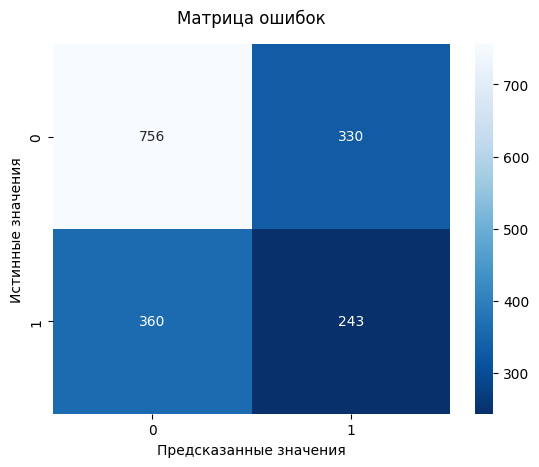

In [28]:
grid_search = GridSearchCV(
    pipe, 
    param_grid, 
    cv=5,
    scoring='f1',
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)

print(f'Лучшая модель и её параметры:\n', grid_search.best_params_)
print('-' * 80)
print(f'Метрика лучшей модели на кросс-валидации: {grid_search.best_score_:.2f}')

y_pred = grid_search.predict(X_test)
y_test_score_f1 = f1_score(y_test, y_pred)
print(f'Метрика F1-score на тестовой выборке: {y_test_score_f1:.3f}')
y_test_score_auc = roc_auc_score(y_test, grid_search.predict_proba(X_test)[:,1])
print(f'Метрика ROC-AUC на тестовой выборке: {y_test_score_auc:.3f}')
y_test_accuracy_score = accuracy_score(y_test, y_pred)
print(f'Метрика Accuracy на тестовой выборке: {y_test_accuracy_score:.3f}')

FP, FN = create_matrix(y_test, y_pred)

model = ModelMetrics('GridSearchCV')
model.model = grid_search.best_estimator_
model.add_metric('F1-score', y_test_score_f1)
model.add_metric('ROC-AUC', y_test_score_auc)
model.add_metric('Accuracy', y_test_accuracy_score)
model.add_metric('FP', FP)
model.add_metric('FN', FN)
models_list[model.model_name] = model

### CatBoostClassifer

#### Базовый CatBoostClassifer

Learning rate set to 0.021171
0:	learn: 0.6911125	total: 140ms	remaining: 2m 19s
200:	learn: 0.5992093	total: 742ms	remaining: 2.95s
400:	learn: 0.5554959	total: 1.36s	remaining: 2.03s
600:	learn: 0.5120677	total: 1.95s	remaining: 1.29s
800:	learn: 0.4723472	total: 2.53s	remaining: 629ms
999:	learn: 0.4391682	total: 3.12s	remaining: 0us
Базовая модель CatBoostClassifer:
--------------------------------------------------------------------------------
Метрика F1-score на тестовой выборке: 0.107
Метрика ROC-AUC на тестовой выборке: 0.568
Метрика Accuracy на тестовой выборке: 0.643


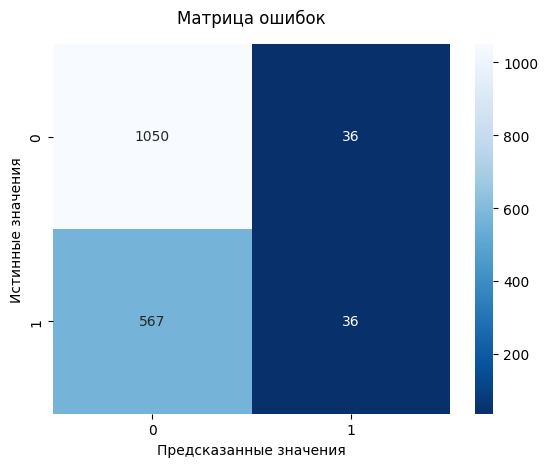

In [29]:
model = ModelMetrics('CatBoostBase')

model.model = CatBoostClassifier(verbose=200)
model.model.fit(X_train, y_train)

print(f'Базовая модель CatBoostClassifer:')
print('-' * 80)
y_pred = model.model.predict(X_test)
y_test_score_f1 = f1_score(y_test, y_pred)
print(f'Метрика F1-score на тестовой выборке: {y_test_score_f1:.3f}')
y_test_score_auc = roc_auc_score(y_test, model.model.predict_proba(X_test)[:,1])
print(f'Метрика ROC-AUC на тестовой выборке: {y_test_score_auc:.3f}')
y_test_accuracy_score = accuracy_score(y_test, y_pred)
print(f'Метрика Accuracy на тестовой выборке: {y_test_accuracy_score:.3f}')

FP, FN = create_matrix(y_test, y_pred)

model.add_metric('F1-score', y_test_score_f1)
model.add_metric('ROC-AUC', y_test_score_auc)
model.add_metric('Accuracy', y_test_accuracy_score)
model.add_metric('FP', FP)
model.add_metric('FN', FN)
models_list[model.model_name] = model

#### RandomizedSearchCV

In [30]:
def train_catboost_classifier(category_cols: list[str], 
                             target_col: str='heart_attack_risk_binary',
                             random_state=42):
    test_pool = Pool(X_test, y_test, cat_features=category_cols)

    param_grid = {
        'iterations': [100, 500, 1500],
        'depth': [4, 8, 12],
        'learning_rate': [0.001, 0.01, 0.1],
        'l2_leaf_reg': [1, 3, 5],
        'eval_metric': ['F1'],
        'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
    }

    model = CatBoostClassifier(
        loss_function='Logloss',
        eval_metric='F1',
        verbose=0,
        random_seed=random_state,
    )

    randomized_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        scoring='f1',
        cv=3,
        verbose=1,
        random_state=RANDOM_STATE
    )

    randomized_search.fit(X_train, y_train,
                    cat_features=category_cols,
                    eval_set=test_pool,
                    early_stopping_rounds=20
    )

    print(f'Лучшая модель и её параметры:\n', randomized_search.best_params_)
    print('-' * 80)

    return randomized_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшая модель и её параметры:
 {'learning_rate': 0.01, 'l2_leaf_reg': 3, 'iterations': 500, 'grow_policy': 'SymmetricTree', 'eval_metric': 'F1', 'depth': 12}
--------------------------------------------------------------------------------
Метрика F1-score на тестовой выборке: 0.166
Метрика ROC-AUC на тестовой выборке: 0.509
Метрика Accuracy на тестовой выборке: 0.618


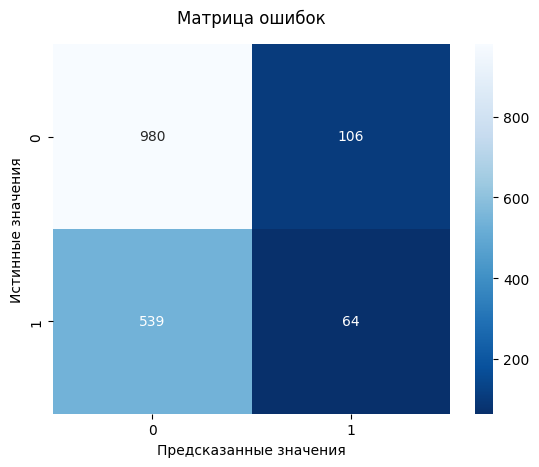

In [31]:
model = ModelMetrics('CatBoostRndSCV')
model.model = train_catboost_classifier(
    [col['col'] for col in category_cols],
    'heart_attack_risk_binary',
    RANDOM_STATE
)

y_pred = model.model.predict(X_test)
y_test_score_f1 = f1_score(y_test, y_pred)
print(f'Метрика F1-score на тестовой выборке: {y_test_score_f1:.3f}')
y_test_score_auc = roc_auc_score(y_test, model.model.predict_proba(X_test)[:,1])
print(f'Метрика ROC-AUC на тестовой выборке: {y_test_score_auc:.3f}')
y_test_accuracy_score = accuracy_score(y_test,  y_pred)
print(f'Метрика Accuracy на тестовой выборке: {y_test_accuracy_score:.3f}')

FP, FN = create_matrix(y_test, y_pred)

model.add_metric('F1-score', y_test_score_f1)
model.add_metric('ROC-AUC', y_test_score_auc)
model.add_metric('Accuracy', y_test_accuracy_score)
model.add_metric('FP', FP)
model.add_metric('FN', FN)
models_list[model.model_name] = model    

### PyTorch

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

#### Модель

In [33]:
pt_binary_cols = [
    'diabetes', 'family_history', 'obesity', 'alcohol_consumption',
    'previous_heart_problems', 'medication_use'] #, 'gender', 'smoking']
pt_category_cols = ['diet', 'stress_level', 'physical_activity_days_per_week']
pt_numeric_cols = [
    'age', 'cholesterol', 'heart_rate', 'exercise_hours_per_week', 'sedentary_hours_per_day',
    'bmi', 'triglycerides', 'blood_sugar', 'ck_mb', 
    'troponin', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'sleep_hours_per_day']#, 'income']

In [34]:
class ClassedDatasetFromPandas(Dataset):
    def __init__(self, data: pd.DataFrame, target: pd.DataFrame):
        assert len(pt_binary_cols + pt_category_cols + pt_numeric_cols) == len(data.columns), 'Некорректное число признаков в датасете!'
        self.data_bin = (data[pt_binary_cols]
            .apply(lambda row: int(''.join(str(x) for x in row), 2), axis=1)
            .values.astype(np.float32))
        self.data_cat = data[pt_category_cols].values.astype(np.int32)
        self.data_num = data[pt_numeric_cols].values.astype(np.float32)
        self.target = target.values.astype(np.float32)
        assert len(self.data_bin) == len(self.data_cat) == len(self.data_num) == len(self.target), 'Потеря данных при создании датасета!'
        
    def __len__(self):
        return len(self.data_num)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.data_bin[idx]),
            torch.tensor(self.data_cat[idx]),
            torch.tensor(self.data_num[idx]),
            torch.tensor(self.target[idx]),
        )

In [35]:
class HeartAttackRiskNN_emb(nn.Module):
    def __init__(
            self,
            inputs: int,
            bins: int=64,
            diet_lvl: int=3,
            stress_lvl: int=10,
            max_days: int=8,
            embedding_size: int=32):
        super().__init__()
        
        self.bins_emb = nn.Embedding(bins, embedding_size * 4)
        self.diet_emb = nn.Embedding(diet_lvl, embedding_size)
        self.stress_emb = nn.Embedding(stress_lvl, embedding_size)
        self.act_day_emb = nn.Embedding(max_days, embedding_size)

        self.linear = nn.Sequential(
            nn.Linear(inputs + 7 * embedding_size, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, 256), nn.BatchNorm1d(256), nn.Mish(), nn.Dropout(0.5),
            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.Mish(), nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

    def forward(
        self,
        X_bin: torch.Tensor,
        X_cat: torch.Tensor,
        X_num: torch.Tensor
    ) -> torch.Tensor:
        bins = self.bins_emb(X_bin.int())
        for i, cat in enumerate(pt_category_cols):
            if cat == 'diet':
                diet = self.diet_emb(X_cat[:, i].int())
            elif cat == 'stress_level':
                stress = self.stress_emb(X_cat[:, i].int())
            elif cat == 'physical_activity_days_per_week':
                act_day = self.act_day_emb(X_cat[:, i].int())
        try:
            features = torch.cat((bins, diet, stress, act_day, X_num), dim=1)
        except RuntimeError:
            print('size bins - ', bins.size())
            print('size diet - ', diet.size())
            print('size stress - ', stress.size())
            print('size act_day - ', act_day.size())
            print('size X_num - ', X_num.size())
        output = self.linear(features)

        return output

#### Обучение

In [36]:
def train_model_emb(target_col: str, 
                epochs: int=100, batch_size: int=128, 
                learning_rate: float=0.001,
                verbose: int=10,
                lr_steps: int=0):
    """Тренирует модель и логирует loss и roc-auc"""
    train_loader = DataLoader(
        ClassedDatasetFromPandas(X_train, y_train),
        batch_size=batch_size,
        shuffle=True)
    test_loader = DataLoader(
        ClassedDatasetFromPandas(X_val, y_val),
        batch_size=batch_size)
    
    model = HeartAttackRiskNN_emb(
        inputs=X_train[pt_numeric_cols].shape[1],
        bins=2**len(pt_binary_cols),
        diet_lvl=X_train.diet.max() + 1,
        stress_lvl=X_train.stress_level.max() + 1,
        max_days=X_train.physical_activity_days_per_week.max() + 1,
        embedding_size=4
    ).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    criterion = nn.BCEWithLogitsLoss()
    
    train_losses = []
    test_losses = []
    train_roc_auc_score = []
    test_roc_auc_score = []
    elapsed_time = 0

    for epoch in range(epochs):
        model.train()
        loss_sum = 0
        predicted = []
        trues = []

        start_time = time.time()
        for X_bin, X_cat, X_num, labels in train_loader:
            X_bin, X_cat, X_num, labels = X_bin.to(device), X_cat.to(device), X_num.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(X_bin, X_cat, X_num)
            loss = criterion(outputs, labels.view(-1, 1))
            loss.backward()
            optimizer.step()
            
            loss_sum += loss.item()
            predicted.append(torch.sigmoid(outputs).detach().cpu().numpy().ravel())
            trues.append(labels.detach().cpu().numpy().ravel())
        
        train_losses.append(loss_sum / len(train_loader))
        train_roc_auc_score.append(roc_auc_score(np.concatenate(trues), np.concatenate(predicted)))
        
        model.eval()
        loss_sum = 0
        predicted = []
        trues = []
        
        with torch.no_grad():
            for X_bin, X_cat, X_num, labels in test_loader:
                X_bin, X_cat, X_num, labels = X_bin.to(device), X_cat.to(device), X_num.to(device), labels.to(device)
                outputs = model(X_bin, X_cat, X_num)
                loss = criterion(outputs, labels.view(-1, 1))
                
                loss_sum += loss.item()
                predicted.append(torch.sigmoid(outputs).detach().cpu().numpy().ravel())
                trues.append(labels.detach().cpu().numpy().ravel())
        
        test_losses.append(loss_sum / len(test_loader))
        test_roc_auc_score.append(roc_auc_score(np.concatenate(trues), np.concatenate(predicted)))
        
        elapsed_time += time.time() - start_time
        if verbose and (epoch+1) % verbose == 0:
            print('Epoch ' + f'{epoch+1}'.rjust(len(str(epochs))) + f'/{epochs} | '
                  f'Train Loss: {train_losses[-1]:.4f} | '
                  f'Val Loss: {test_losses[-1]:.4f} | '
                  f'Train ROC-AUC: {train_roc_auc_score[-1]:.4f} | '
                  f'Val ROC-AUC: {test_roc_auc_score[-1]:.4f} | '
                  f'Time: {elapsed_time:.2f} sec')
            elapsed_time = 0

        if lr_steps and (epoch+1) % (epochs // lr_steps) == 0:
            scheduler.step()
        
    return model, train_losses, test_losses, train_roc_auc_score, test_roc_auc_score

In [37]:
model_nn, train_losses, test_losses, train_roc_auc_score, test_roc_auc_score = train_model_emb(
    'heart_attack_risk_binary',
    epochs=1000,
    verbose=50,
    batch_size=512,
    learning_rate=0.01,
    lr_steps=20
)

with torch.no_grad():
    data_set = ClassedDatasetFromPandas(X_test, y_test)
    data_loader = DataLoader(data_set, batch_size=len(data_set))
    X_bin, X_cat, X_num, labels = next(iter(data_loader))
    outputs = model_nn(X_bin.to(device), X_cat.to(device), X_num.to(device))
    y_pred = torch.sigmoid(outputs).detach().cpu().numpy().ravel()

model = ModelMetrics('Torch')
model.model = model_nn.cpu()
model.add_metric('ROC-AUC', roc_auc_score(y_test, y_pred))
model.predict = y_pred

print(f'Модель {model.model.__class__.__name__}:')
print('-' * 80)
print(f'Метрика ROC-AUC на тестовой выборке: {model.metrics['ROC-AUC']:.2f}')

models_list[model.model_name] = model

Epoch   50/1000 | Train Loss: 0.5639 | Val Loss: 0.7101 | Train ROC-AUC: 0.7443 | Val ROC-AUC: 0.5379 | Time: 12.82 sec
Epoch  100/1000 | Train Loss: 0.4453 | Val Loss: 0.8874 | Train ROC-AUC: 0.8582 | Val ROC-AUC: 0.5460 | Time: 13.00 sec
Epoch  150/1000 | Train Loss: 0.3774 | Val Loss: 0.9884 | Train ROC-AUC: 0.8990 | Val ROC-AUC: 0.5632 | Time: 12.91 sec
Epoch  200/1000 | Train Loss: 0.3586 | Val Loss: 1.0853 | Train ROC-AUC: 0.9125 | Val ROC-AUC: 0.5451 | Time: 13.03 sec
Epoch  250/1000 | Train Loss: 0.3326 | Val Loss: 1.2065 | Train ROC-AUC: 0.9251 | Val ROC-AUC: 0.5457 | Time: 13.17 sec
Epoch  300/1000 | Train Loss: 0.3045 | Val Loss: 1.2594 | Train ROC-AUC: 0.9376 | Val ROC-AUC: 0.5560 | Time: 12.97 sec
Epoch  350/1000 | Train Loss: 0.2915 | Val Loss: 1.2868 | Train ROC-AUC: 0.9427 | Val ROC-AUC: 0.5509 | Time: 12.61 sec
Epoch  400/1000 | Train Loss: 0.2801 | Val Loss: 1.2974 | Train ROC-AUC: 0.9479 | Val ROC-AUC: 0.5480 | Time: 12.83 sec
Epoch  450/1000 | Train Loss: 0.2548 | V

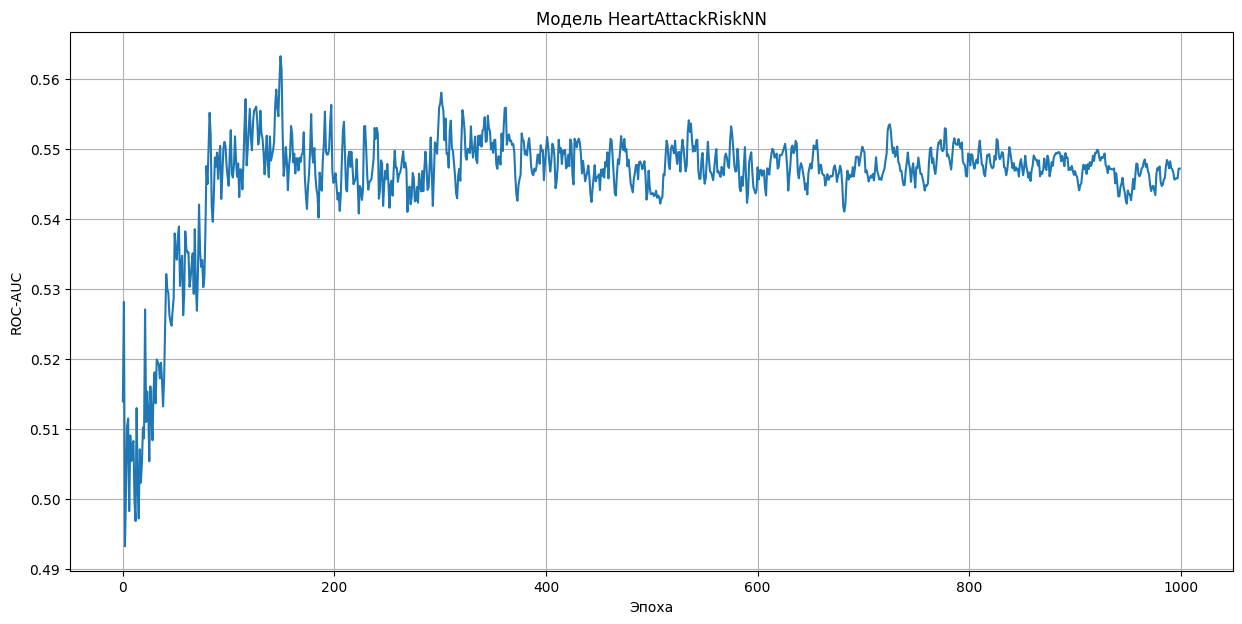

In [38]:
plt.figure(figsize=(15, 7))
plt.plot(test_roc_auc_score)
plt.grid()
plt.xlabel('Эпоха')
plt.ylabel('ROC-AUC')
plt.title('Модель HeartAttackRiskNN')
plt.show()

#### Выбор порогов для Accuracy и F1

In [39]:
def create_metrics_data(y_true, y_predict, start, stop, bins):
    metrics = pd.DataFrame(columns=['Precision', 'Recall', 'Acc', 'F1', 'FP', 'FN', 'Предсказано 1', 'Всего 1'])

    for i in np.linspace(start, stop, num=bins, endpoint=False):
        func = np.vectorize(lambda x: 1 if x > i else 0)
        y_proba = func(y_predict)
        metrics.loc['th_' + str(round(i,2))] = [
            precision_score(y_true, y_proba, zero_division=0),
            recall_score(y_true, y_proba, zero_division=0),
            accuracy_score(y_true, y_proba),
            f1_score(y_true, y_proba),
            confusion_matrix(y_true, y_proba)[0, 1],
            confusion_matrix(y_true, y_proba)[1, 0],
            y_proba.sum(),
            y_test.sum()
        ]
    return metrics

def draw_metrics_data(metrics, title):
    plt.figure(figsize=(15, 7))

    for col in ['Precision', 'Recall', 'Acc', 'F1']:
        plt.plot(metrics[col], label=col)

    plt.grid()
    plt.title(label=title)
    plt.xlabel(xlabel='Порог классификации')
    plt.ylabel(ylabel='Значение')
    plt.legend()
    plt.show()

<Axes: >

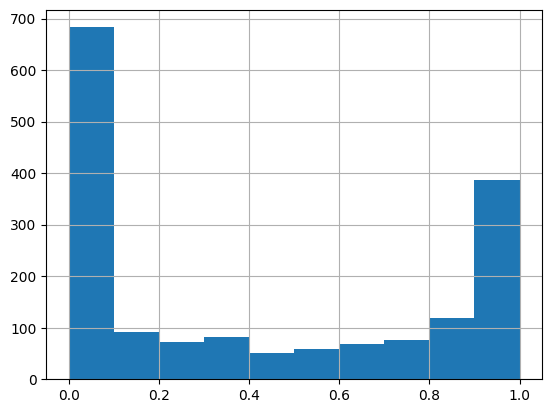

In [40]:
pd.Series(model.predict).hist()

,Precision,Recall,Acc,F1,FP,FN,Предсказано 1,Всего 1
th_0.1,0.374,0.624,0.493,0.467,630.000,227.000,"1,006.000",603.000
th_0.15,0.379,0.597,0.507,0.464,589.000,243.000,949.000,603.000
th_0.2,0.377,0.572,0.510,0.455,569.000,258.000,914.000,603.000
th_0.25,0.376,0.544,0.515,0.445,544.000,275.000,872.000,603.000
th_0.3,0.375,0.522,0.518,0.436,526.000,288.000,841.000,603.000
th_0.35,0.376,0.494,0.526,0.427,495.000,305.000,793.000,603.000
th_0.4,0.378,0.476,0.533,0.421,472.000,316.000,759.000,603.000
th_0.45,0.381,0.464,0.539,0.419,455.000,323.000,735.000,603.000
th_0.5,0.379,0.444,0.541,0.409,440.000,335.000,708.000,603.000
th_0.55,0.385,0.430,0.551,0.406,414.000,344.000,673.000,603.000


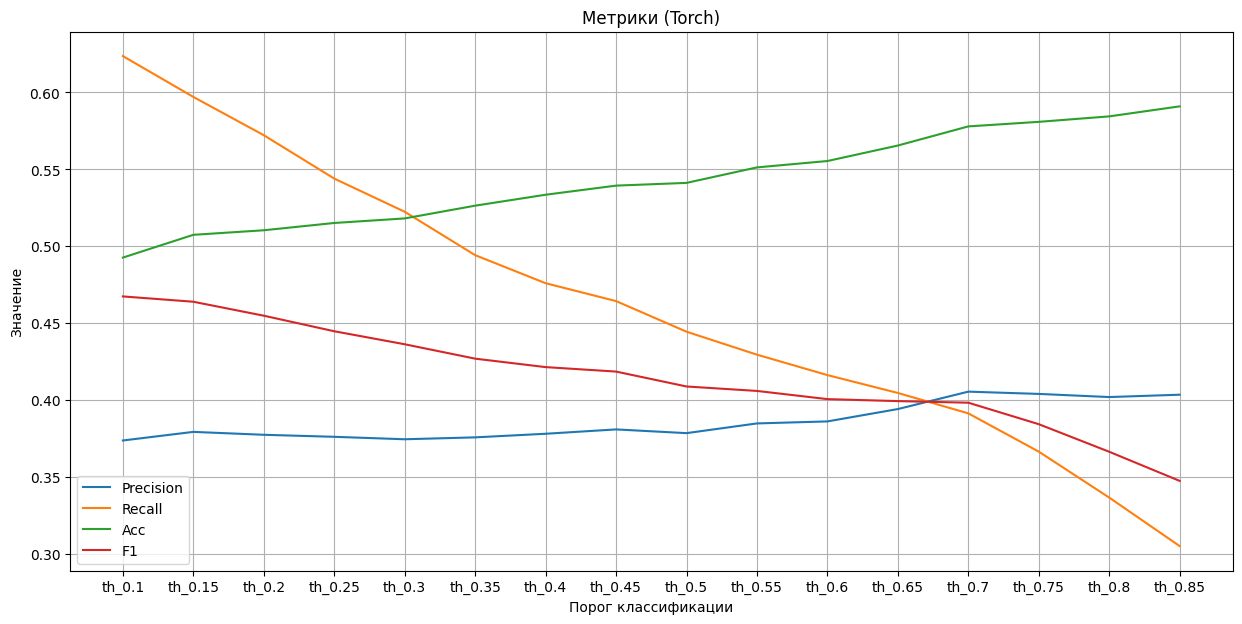

In [41]:
for model in [model for model in models_list.values() if 'Torch' in model.model_name]:
    metrics = create_metrics_data(y_test, model.predict, 0.1, 0.9, 16)
    display(metrics)
    draw_metrics_data(metrics, f'Метрики ({model.model_name})')

Модель Torch:
--------------------------------------------------------------------------------
Метрика F1-score на тестовой выборке: 0.43
Метрика Accuracy на тестовой выборке: 0.53
              precision    recall  f1-score   support

           0       0.66      0.54      0.60      1086
           1       0.38      0.49      0.43       603

    accuracy                           0.53      1689
   macro avg       0.52      0.52      0.51      1689
weighted avg       0.56      0.53      0.54      1689



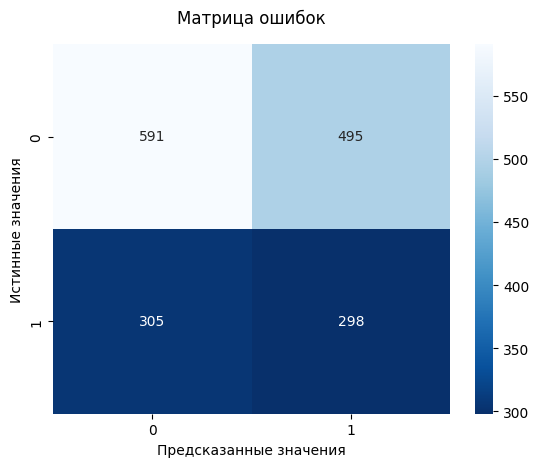

In [56]:
func = np.vectorize(lambda data, th: 1 if data > th else 0)
treshold = 0.35
for model in [model for model in models_list.values() if 'Torch' in model.model_name]:
    print(f'Модель {model.model_name}:')
    print('-' * 80)
    y_pred = func(model.predict, treshold)
    y_test_score_f1 = f1_score(y_test, y_pred)
    print(f'Метрика F1-score на тестовой выборке: {y_test_score_f1:.2f}')
    y_test_accuracy_score = accuracy_score(y_test,  y_pred)
    print(f'Метрика Accuracy на тестовой выборке: {y_test_accuracy_score:.2f}')

    FP, FN = create_matrix(y_test, y_pred)

    model.add_metric('F1-score', y_test_score_f1)
    model.add_metric('Accuracy', y_test_accuracy_score)
    model.add_metric('FP', FP)
    model.add_metric('FN', FN)


    from sklearn.metrics import classification_report
    print(classification_report(y_test, y_pred))

In [66]:
data_set = ClassedDatasetFromPandas(X_val)
data_loader = DataLoader(data_set, batch_size=len(data_set))
X_bin, X_cat, X_num = next(iter(data_loader))
traced_model = torch.jit.trace(models_list['Torch'].model, example_inputs=(X_bin, X_cat, X_num))
torch.jit.save(traced_model, os.path.join(PRO_PATH, 'jit_model_230625_1141.pt'))

In [72]:
torch.jit.save(traced_model, 'jit_model_230625_1141.pt')

### Dummy

Модель DummyClassifier:
--------------------------------------------------------------------------------
Метрика F1-score на тестовой выборке: 0.00
Метрика ROC-AUC на тестовой выборке: 0.50
Метрика Accuracy на тестовой выборке: 0.64


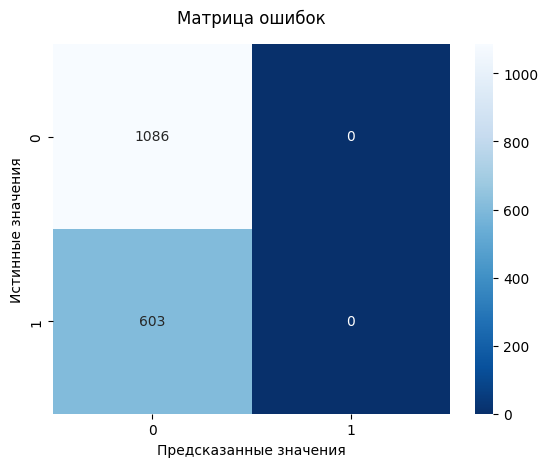

In [43]:
model = DummyClassifier(strategy="most_frequent", random_state=0)
model.fit(X_train, y_train)
    
print(f'Модель DummyClassifier:')
print('-' * 80)

y_pred = model.predict(X_test)
y_test_score_f1 = f1_score(y_test, y_pred)
print(f'Метрика F1-score на тестовой выборке: {y_test_score_f1:.2f}')
y_test_score_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
print(f'Метрика ROC-AUC на тестовой выборке: {y_test_score_auc:.2f}')
y_test_accuracy_score = accuracy_score(y_test,  y_pred)
print(f'Метрика Accuracy на тестовой выборке: {y_test_accuracy_score:.2f}')

FP, FN = create_matrix(y_test, y_pred)
    
model = ModelMetrics('DummyClassifier')
model.model = model
model.add_metric('F1-score', y_test_score_f1)
model.add_metric('ROC-AUC', y_test_score_auc)
model.add_metric('Accuracy', y_test_accuracy_score)
model.add_metric('FP', FP)
model.add_metric('FN', FN)
models_list[model.model_name] = model

### Сравнение

In [44]:
def draw_metric(metric: str):
    roc_auc_df = pd.DataFrame(
        [(model.model_name, model.metrics[metric]) for model in models_list.values()],
        columns=['name', 'value']
    ).sort_values(by='value').reset_index(drop=True)
    
    plt.figure(figsize=(15, 5))
    plt.xticks(rotation=45)
    plt.grid()
    plt.title(f'Метрика {metric} для разных моделей (тестовая выборка)')
    plt.xlabel('Модель')
    plt.ylabel(metric)
    plt.bar(x=roc_auc_df.name, height=roc_auc_df.value);
    plt.show()

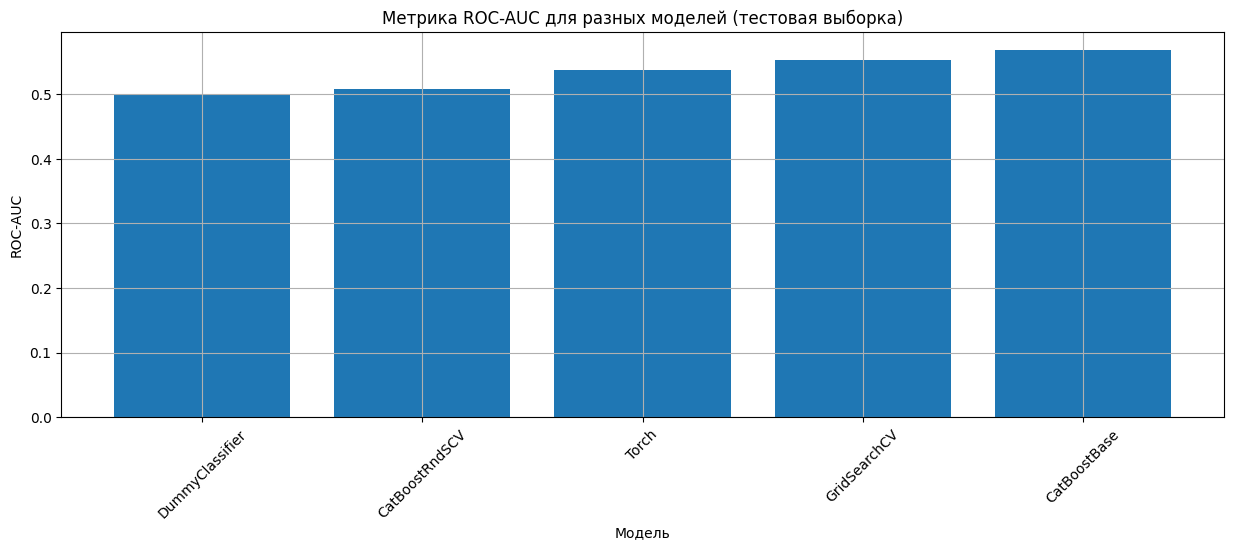

In [57]:
draw_metric('ROC-AUC')

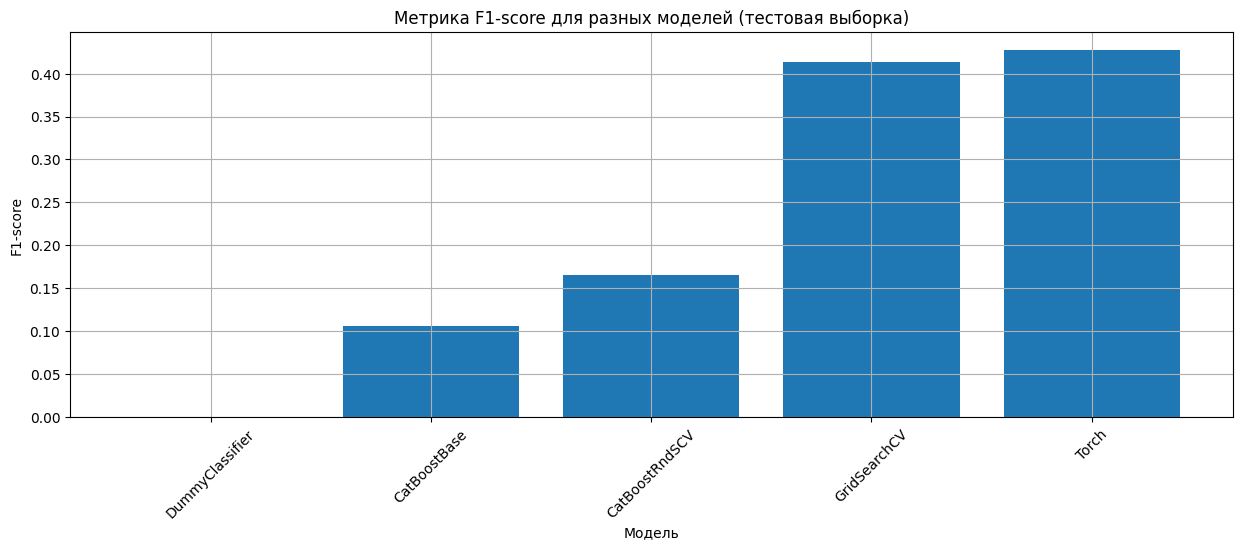

In [58]:
draw_metric('F1-score')

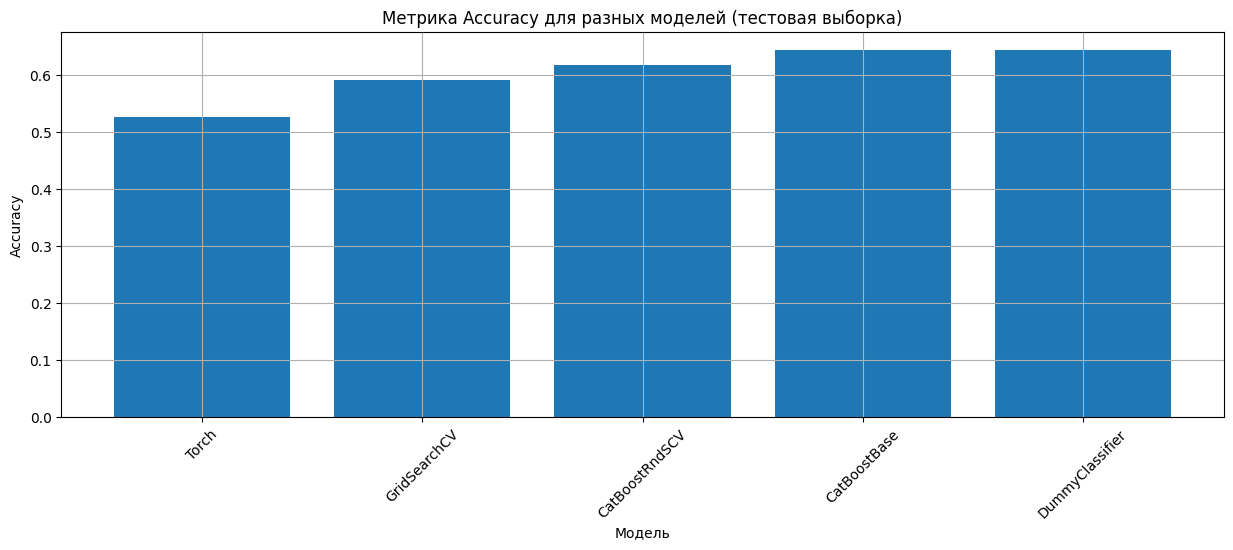

In [59]:
draw_metric('Accuracy')

### Вывод

В ходе данного шага:
- С помощью GridSearchCV осуществлен подпор модели и её гиперпараметров. Лучшее значение метрики ROC-AUC (как для исходного набора данных, так и для предобработанного с помощью библиотеки `SMOTEENN`) показала модель `{'models': KNeighborsClassifier(), 'models__algorithm': 'auto', 'models__n_neighbors': 2, 'models__weights': 'distance'}`
- Обучена модель `CatBoostClassifer` (с настройками по умолчанию и с перебором гиперпараметров)
- Разработана и обучена нейронная сеть (на базе фреймворка `PyTorch`)
- Проведено сравнение метрики ROC-AUC для обученных моделей и модели `DummyClassifer`
Лучший показатель ROC-AUC и F1 у модели на `PyTorch`
Модель, обученная на CatBoost показала отвратительные значения TP и FN

## Пайплайн и предсказание

Здесь собираю все нужные для предсказания функции

In [49]:
def rename_columns_to_snake_case(df: pd.DataFrame, inplace: bool=False) -> pd.DataFrame:
    """Переименовывает все столбцы DataFrame в стиль snake_case."""
    column_mapping = {col: re.sub(r'[()]', '', col).lower().replace(' ', '_').replace('-', '_') for col in df.columns}
    return df.rename(columns=column_mapping, inplace=inplace)

In [50]:
def dropna_with_control(df: pd.DataFrame, name: str=None) -> pd.DataFrame:
    """
    Функция для безопасного удаления строк с пропущенными значениями из DataFrame.
    Дополнительно корректирует столбец "gender", при наличии.
    """
    data = df.copy()

    data_loss = data.isna().sum().max() / len(data)
    start_size = data.shape

    data.dropna(inplace=True)
    assert data.shape[0] == start_size[0] * (1 - data_loss), 'Потери данных превышают теоретические!'
    assert data.shape[1] == start_size[1], 'При исключении пропусков потеряны колонки!'
    if name:
        print(f'Удалено пропусков в {name}:', start_size[0] - data.shape[0])
        print(f'Остаток данных: {(data.shape[0] / start_size[0] * 100):.2f}%')

    if 'gender' in data:  
        assert sorted(data.gender.unique()) == sorted(['Female', 'Male']), f'Ошибка при удалении данных из {data.gender.unique()}'
        data['gender'] = data['gender'].apply(lambda x: 0 if x == 'Female' else 1)
        assert sorted(data.gender.unique()) == sorted([0, 1]), f'Ошибка при замене "gender" данных из {name}'
    
    return data

In [51]:
def convert_float_to_int(df: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    """Функция для преобразования значений указанных колонок из float в int."""
    assert df[columns].isna().sum().sum() == 0, "В данных присутствуют NaN"

    data = df.copy()

    for col in columns:
        data[col] = data[col].astype(int)
    
    assert data.shape == df.shape, "Размер DataFrame изменился после преобразования"
    for col in columns:
        assert np.issubdtype(data[col].dtype, np.integer), f"Колонка {col} не была преобразована в int"
    
    return data

In [52]:
class ClassedDatasetFromPandas(Dataset):
    def __init__(self, data: pd.DataFrame):
        assert len(pt_binary_cols + pt_category_cols + pt_numeric_cols) == len(data.columns), 'Некорректное число признаков в датасете!'
        self.data_bin = (data[pt_binary_cols]
            .apply(lambda row: int(''.join(str(x) for x in row), 2), axis=1)
            .values.astype(np.float32))
        self.data_cat = data[pt_category_cols].values.astype(np.int32)
        self.data_num = data[pt_numeric_cols].values.astype(np.float32)
        assert len(self.data_bin) == len(self.data_cat) == len(self.data_num), 'Потеря данных при создании датасета!'
        
    def __len__(self):
        return len(self.data_num)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.data_bin[idx]),
            torch.tensor(self.data_cat[idx]),
            torch.tensor(self.data_num[idx]),
        )

In [53]:
pt_binary_cols = [
    'diabetes', 'family_history', 'obesity', 'alcohol_consumption',
    'previous_heart_problems', 'medication_use']
pt_category_cols = ['diet', 'stress_level', 'physical_activity_days_per_week']
pt_numeric_cols = [
    'age', 'cholesterol', 'heart_rate', 'exercise_hours_per_week', 'sedentary_hours_per_day',
    'bmi', 'triglycerides', 'blood_sugar', 'ck_mb', 
    'troponin', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'sleep_hours_per_day']

In [54]:
def predict_pipeline(df: pd.DataFrame) -> pd.DataFrame:
    df_id = pd.DataFrame({'id': df.id})
    rename_columns_to_snake_case(df, inplace=True)
    df = dropna_with_control(df)
    df = convert_float_to_int(df, pt_binary_cols + pt_category_cols)

    model = torch.load(os.path.join(PRO_PATH, 'model_200625_1608.pt'), weights_only=False).to(device)
    
    with torch.no_grad():
        data_set = ClassedDatasetFromPandas(df[pt_binary_cols+pt_category_cols+pt_numeric_cols])
        data_loader = DataLoader(data_set, batch_size=len(data_set))
        X_bin, X_cat, X_num= next(iter(data_loader))
        outputs = model(X_bin.to(device), X_cat.to(device), X_num.to(device))
        y_pred = torch.sigmoid(outputs).detach().cpu().numpy().ravel()

    return pd.merge(df_id, pd.DataFrame({'id': df.id, 'predict': y_pred}),on='id', how='left').fillna(0.5)   

In [55]:
test_data = pd.read_csv(os.path.join(PRO_PATH, 'heart_test.csv'))
predict_pipeline(test_data).to_csv(os.path.join(PRO_PATH, 'heart_test_predict.csv'), index=False)

## Выводы и рекомендации

В рамках работы по построению моделей предсказания удовлетворённости сотрудника компании и предсказания увольнения сотрудника из компании для HR-аналитиков компании «Работа с заботой» выполнено:

1. Проведена загрузка и первичная оценка соответствия данных. Обнаружены незначительные пропуски в данных
2. Проведена предобработка данных:
    - Наименования колонок приведены к snake_case
    - Проверено наличия явных дубликатов. Явные дубликаты не обнаружены.
    - Проверено наличие дубликатов `id` записей. Дубликатов нет
    - Проверено наличие явных пропусков - пропусков менее 5% от всего датасета.
3. Проведен анализ пропусков. Анализ показал, что:
    - все пропуски находятся в одних и тех же строках;
    - аномальные (не поддающиеся однозначной трактовке) значения признака `gender` находятся в строках с пропущенными значениями,
    - в строках без пропусков нет аномальных значений признака `gender` (только `Male` и `Female`)
    - в строках с пропусками значение признака `diet` == 3, в строках без пропусков  `diet` == [0, 2]
    - в трети признаков данне фиктивные (например, `cholesterol` == 0.5 для всех строк).

Принято решение исключить данные из датасетов

4. Проведён исследовательский анализ данных. По результатам исследовательского анализа данных установлено:
    - Распределение бинарных признаков, в основном, равномерное. Исключения - некурящие пациенты (менее 10% данных), женщины (около 30%) и диабетики (65%).
    - Категориальные признаки распределены равномерно, перекосов нет.
    - Непрерывные признаки распределены, в основном, нормально. Признаки отнормированы.
    - Явных зависимостей целевого признака от конкретного признака не установлено, что подтверждается матрицей корреляции.
    - Корреляционная матрица показала сильную зависимость признака `Курение` от признака `Возраст` и `Пол`. Так, в данных отсутствуют записи о некурящих мужчинах. Также отсутствуют данные о некурящих пациентах в возрасте более 0.3 у.е.
    - Имеется умеренная корреляция между признаками `Уровень сахара`, `Возраст`, `ЧСС`, `Уровень тропонина` и `Уровень фермента креатинкиназы`.

По результатам исследования принято решение сократить датасет, исключив признаки `Пол` (влияние пола второстепенное), `Курение` (косвенный признак, скорее влияет на рак) и `Доход`.

5. Проведено обучение и оценка нескольких моделей. В ходе данного шага:
    - С помощью GridSearchCV осуществлен подпор модели и её гиперпараметров. Лучшее значение метрики ROC-AUC (как для исходного набора данных, так и для предобработанного с помощью библиотеки `SMOTEENN`) показала модель `{'models': KNeighborsClassifier(), 'models__algorithm': 'auto', 'models__n_neighbors': 2, 'models__weights': 'distance'}`
    - Обучена модель `CatBoostClassifer` (с настройками по умолчанию и с перебором гиперпараметров)
    - Разработана и обучена нейронная сеть (на базе фреймворка `PyTorch`)
    - Проведено сравнение метрики ROC-AUC для обученных моделей и модели `DummyClassifer`

Лучший показатель ROC-AUC и F1 у модели на `PyTorch`.

Модель, обученная на CatBoost показала отвратительные значения TP и FN

6. Получено предсказание для тестовых данных